# <center> Statistical analysis of musical genres and popularity, prediction models, regression and multiclassification over spotify song tracks database. </center>

# Table of Contents

0. Introduction
1. Building the dataset
2. Kmeans++
3. Gaussian Mixture Model
4. Naive Bayes Classifier
5. Decision Trees
6. Predicting Popularity
7. Conclusion
8. Extra code and classes implementations

# Chapter 0 - Introduction
We all know that music has been an ubiquitous part of humanity. During the centuries songs and artist have evolved, along with the music industry. If 10-15 years ago it was normal to have collection of CDs now it's the era of streaming. And in the BigData age when you provide a service to people via the internet, data are inevitable collected. Indeed for building our dataset we will use the **Spotify for Developers API** , that provides as very nice features and informations about any track present in their database, and playable by any of us.

## 0.1 - Features

But what kind of attributes are available for each song? First of all we have non-technical related data, such us the popolarity of a song, the number of followers the aritst that plays it have, the musical genre of the track, the track ID and web URL. Then we have some nice features that describes various aspects of a piece of music:

* **Acousticness** : A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

* **Danceability** : Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

* **Energy** : Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

* **Instrumentalness** : Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

* **Loudness** : The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.

* **Speechiness** : Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

* **Valence** : A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

* **Tempo** : The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

* **Time_signature** : An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4".

* **Mode** : Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

* **Key** : The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.

* **Duration** : The duration of the track in milliseconds.

Also as anticipated before, we have access to the popolarity of a song, a value beetween 0 and 100, computed by spotify algorithms based on the number of listeners and the time period of the streams (see later for more details).

# Chapter 1 - Building the Dataset 

## 1.1 - Data Gathering

We connect to the spotifi API (spotipy) in order to retreive the dataset for our work. 
Let's go step by step into this process

In [1]:
import pip 
import os

# Only package not included with python
try : 
    import spotipy
except ImportError : 
    pip.main(['install', 'spotipy'])
    import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import numpy as np 
import pandas as pd

c:\Users\devin\anaconda3\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:
# Set this to false if already have the CSVs ready
save_csv = False

# If flag set to false then csvs are loaded from cvs_dir_name searching for csvs with name "genre.csv" where the genres are specified in the cell below§
grab_from_api = False
csv_dir_name = 'data/csvs/dirty' 

# IF true after cleaning the dataset combine all the frames into a single one and save them into all_clean_path
save_all_clean = False
all_clean_path = 'dataframeV1.csv'

# Save in separate files after cleaning, usefull for the first analysys part
save_separate = False

### Genres selection

We decided to focus on classic, jazz, metal and rap as we believe those are genres that greatly differs between each other, while at the same time sharing some common gray zones

In [3]:
genres = ['classic', 'jazz', 'metal', 'rap']

Loading spotify public and private key, and authentication

In [4]:
credentials = {
    'public' : 'e2b7e92cf8684577a314a8804b97337a', 
    'private': 'a847df678a5145d0a62381b255e4e4fd'
    }

client_credentials_manager = SpotifyClientCredentials(client_id=credentials['public'], client_secret=credentials['private'])
spotyCarlo = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

Interaction with the API

In [5]:
#TODO : Clean this function 
def createFrameFromUrl(url,  carlo = spotyCarlo) : 

    URI = url.split("/")[-1].split("?")[0]
    offs = 0
    feats = list()
    
    # Spotify Limit the number of items that it can be sent in a request to 100 so we have to loop adding offset untill empty body in response
    while True:
        # NOTE:  playlist_track method works only wor playlists made by users ... not genres !!!!
        track_uris = [x["track"]["uri"] for x in carlo.playlist_tracks(URI,offset=offs)["items"]]
        # Empty body
        if track_uris == [] : 
            break
        feats += carlo.audio_features(track_uris)
        offs += 100
    return pd.DataFrame(feats)


In [6]:
# We then extract the dataframes for each genre and for each playlist of the genres and save them into a dictionary. so it is easy to concatenate them
if grab_from_api == True:
    dF_dict = {x : [] for x in genres}
    for genre in genres :     
        with open(os.path.join('urls', ''.join((genre, '_url.txt'))), 'r') as f:
            for uri in f.readlines():
                uri = uri.strip()
                try:
                    dF_dict[genre].append(createFrameFromUrl(uri))
                except : 
                    print(f"failed on {genre}")
                    
        # This will raise error if nothing were retrieved
        dF_dict[genre] = pd.concat([x for x in dF_dict[genre]])
        if save_csv : 
            dF_dict[genre].to_csv(os.path.join(('csvs', genre + '.csv')))
# IF cvs already exist
else: 
    dF_dict = {genre : pd.read_csv(os.path.join(csv_dir_name, genre + '.csv'), index_col=0) for genre in genres}
    

## 1.2 - Cleaning

Cleaning the dataset from duplicates and missing values, moreover we add the label column for the genre.

In [7]:
# Now we clean the dataset from duplicates and missing values, moreover we add the label column for the genre
def cleanFrame(dF, col_to_drop = ['track_href', 'analysis_url', 'type'], genre = '') : 
    report = {
        'duplicate_found' : 0, 
        'NaN_found' : 0, 
        'number_of_instances' : 0,
        'labeled' : False
    }

    i_obs, _ = dF.shape

    # Dropping columns we do not need
    fin = dF.drop(col_to_drop, axis = 1) 

    fin = fin.drop_duplicates(subset='id', keep = 'first')
    d_obs, _ = fin.shape
    report['duplicate_found'] = i_obs - d_obs

    fin = fin.dropna(how = 'any')
    n_obs, _ = fin.shape
    report['NaN_found'] = d_obs - n_obs

    report['number_of_instances'] = n_obs

    if genre != '' : 
        y  = pd.DataFrame([genre for _ in range(n_obs)], columns=['genre'])
        fin['label'] = genre
        report['labeled'] = True

    return fin, report


In [8]:
report = {}


for gen in genres : 
    dF_dict[gen], report[gen] = cleanFrame(dF_dict[gen], genre=gen)
    if save_separate : 
        dF_dict[gen].to_csv(gen + '_cleaned.csv')

if save_all_clean :
    merged = pd.concat([dF_dict[x] for x in genres])
    merged.to_csv(all_clean_path)

    

In [9]:
for rep in report : 
    print(f"Report of {rep}:\n\t {report[rep]}\n" + "-"*100)

Report of classic:
	 {'duplicate_found': 4, 'NaN_found': 0, 'number_of_instances': 244, 'labeled': True}
----------------------------------------------------------------------------------------------------
Report of jazz:
	 {'duplicate_found': 18, 'NaN_found': 0, 'number_of_instances': 382, 'labeled': True}
----------------------------------------------------------------------------------------------------
Report of metal:
	 {'duplicate_found': 4, 'NaN_found': 0, 'number_of_instances': 406, 'labeled': True}
----------------------------------------------------------------------------------------------------
Report of rap:
	 {'duplicate_found': 5, 'NaN_found': 0, 'number_of_instances': 350, 'labeled': True}
----------------------------------------------------------------------------------------------------


## 1.3 - Adding popularity and number of followers

In [10]:
if False:
    dF = pd.read_csv('.\csvs\---Top50_clean.csv', index_col=0)

    def addPop(id):
        return spotyCarlo.track(id)['popularity']

    dF.insert(15,'popularity',np.array(list(map(addPop,dF.iloc[:,11]))))
    dF.to_csv('.\csvs\---Top50_clean.csv')


In [11]:
if False:
    dF = pd.read_csv('.\csvs\data----.csv', index_col=0)
    def addFollwers(id):
        ArtId = spotyCarlo.track(id)['artists'][0]['id']
        return spotyCarlo.artist(ArtId)['followers']['total']
    dF.insert(17,'artist_followers',np.array(list(map(addFollwers,dF.iloc[:,11]))))

## Final complete dataset :

In [12]:
dF = pd.read_csv('data\csvs\dataframeV2.csv',index_col=0)
ind = np.arange(0,dF.shape[0])
dF.insert(0,'ind',ind)
dF.set_index('ind',inplace=True)
dF.sample(8,random_state=4321)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,uri,duration_ms,time_signature,label,popularity,artist_followers
ind,,,,,,,,,,,,,,,,,,
1354,0.872,0.4470,9,-9.487,0,0.5600,0.50800,0.000000,0.1470,0.6140,144.923,0nmW4fvqTwUDjlz13MNpJU,spotify:track:0nmW4fvqTwUDjlz13MNpJU,145711,4,rap,71,37668
690,0.519,0.9820,7,-3.547,1,0.1080,0.00203,0.000550,0.0971,0.3610,97.745,4E5xVW505akJX0wcKj8Mpd,spotify:track:4E5xVW505akJX0wcKj8Mpd,319267,4,metal,66,4102407
268,0.476,0.0794,9,-19.166,0,0.0365,0.95500,0.872000,0.1120,0.1180,103.181,1wnbi9NzQPBCobZ6OYCpqH,spotify:track:1wnbi9NzQPBCobZ6OYCpqH,162680,4,jazz,52,220890
1342,0.854,0.5080,8,-8.818,1,0.2620,0.22700,0.000013,0.1490,0.4860,146.137,4SkIdCA9Vp7XXSAlYGtohn,spotify:track:4SkIdCA9Vp7XXSAlYGtohn,185753,4,rap,64,405709
148,0.159,0.0397,7,-23.837,1,0.0453,0.96400,0.847000,0.1190,0.0749,92.650,5EGQC8qSbx5xQD8dlat1R3,spotify:track:5EGQC8qSbx5xQD8dlat1R3,219693,4,classic,50,73534
108,0.119,0.0310,2,-31.179,1,0.0483,0.96400,0.165000,0.1110,0.0388,88.858,123zFAGx0F5ScgrLrCWGDX,spotify:track:123zFAGx0F5ScgrLrCWGDX,156573,4,classic,56,1159118
1374,0.824,0.6240,5,-7.485,0,0.0793,0.00919,0.014700,0.1070,0.6950,160.084,4zH7cV5EXNJAi0n4aFlIxM,spotify:track:4zH7cV5EXNJAi0n4aFlIxM,149062,4,rap,52,146149
687,0.600,0.9310,7,-4.647,1,0.0734,0.02960,0.000071,0.3920,0.5420,140.123,5xLyTbCFONUGUuG0LtUxjn,spotify:track:5xLyTbCFONUGUuG0LtUxjn,270427,4,metal,20,4044076


## 1.4 - Plots and visualizations

Now that our dataset is ready, let's see what we can perceive from it looking at some graphical views

In [13]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
sns.set_style('ticks')

# mcfadden - pseudo R2 

In [14]:
metal_df = pd.read_csv("data//csvs//metal_cleaned.csv")
rap_df = pd.read_csv("data//csvs//rap_cleaned.csv")
classic_df = pd.read_csv("data//csvs//classic_cleaned.csv")
jazz_df = pd.read_csv("data//csvs//jazz_cleaned.csv")

In [15]:
feat = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'duration_ms','tempo', 'time_signature']
metal_df['duration_ms'] = metal_df['duration_ms']/1000
rap_df['duration_ms'] = rap_df['duration_ms']/1000
classic_df['duration_ms'] = classic_df['duration_ms']/1000
jazz_df['duration_ms'] = jazz_df['duration_ms']/1000

The dataframes are already cleaned so we can go ahead and create some plots. Let's start by seeing if we can catch any pecularities in our features, divided by genres:

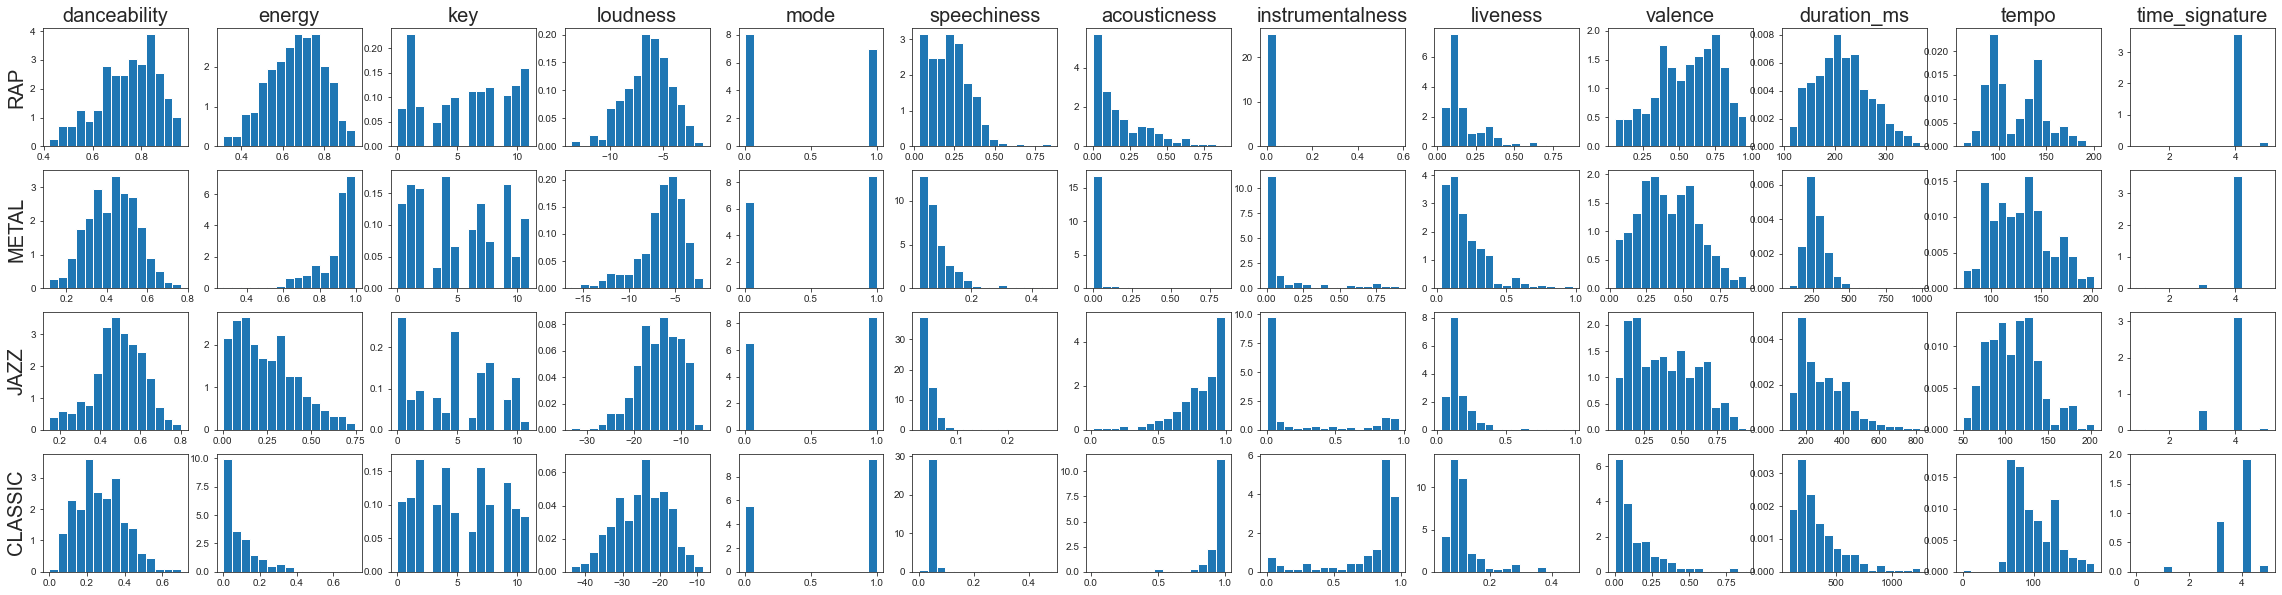

In [16]:
_, ax = plt.subplots(ncols=len(feat), nrows=4, figsize=(40,10)) 

for i in range(len(feat)) :
    if i == 0 :
        ax[0][i].set_ylabel("RAP", fontsize = 20)
        ax[1][i].set_ylabel("METAL", fontsize = 20)
        ax[2][i].set_ylabel("JAZZ", fontsize = 20)
        ax[3][i].set_ylabel("CLASSIC", fontsize = 20)
    ax[0][i].set_title(feat[i], fontsize=20)
    ax[0][i].hist(rap_df.loc[:, feat[i]], density = True, label = feat[i],bins=15)
    ax[1][i].hist(metal_df.loc[:, feat[i]], density = True, label = feat[i],bins=15)
    ax[2][i].hist(jazz_df.loc[:, feat[i]], density = True, label = feat[i],bins=15)
    ax[3][i].hist(classic_df.loc[:, feat[i]], density = True, label = feat[i],bins=15)


Some simple observations:
* The most energized genres are metal and rap, while jazz anc classic prefer to take it easy.
* Jazz and Classic pieces relies a lot on acoustic intruments, while metal and rap like more electricity and technology.
* The most variation in the time_signature is present in Classic music, indeed there are a lot of pieces with 3/4 tempo.
* Instrumentalness is at the top for Classic tracks, as expected.

Let's now take a look of how those classes are "clustered" pairing each feature:

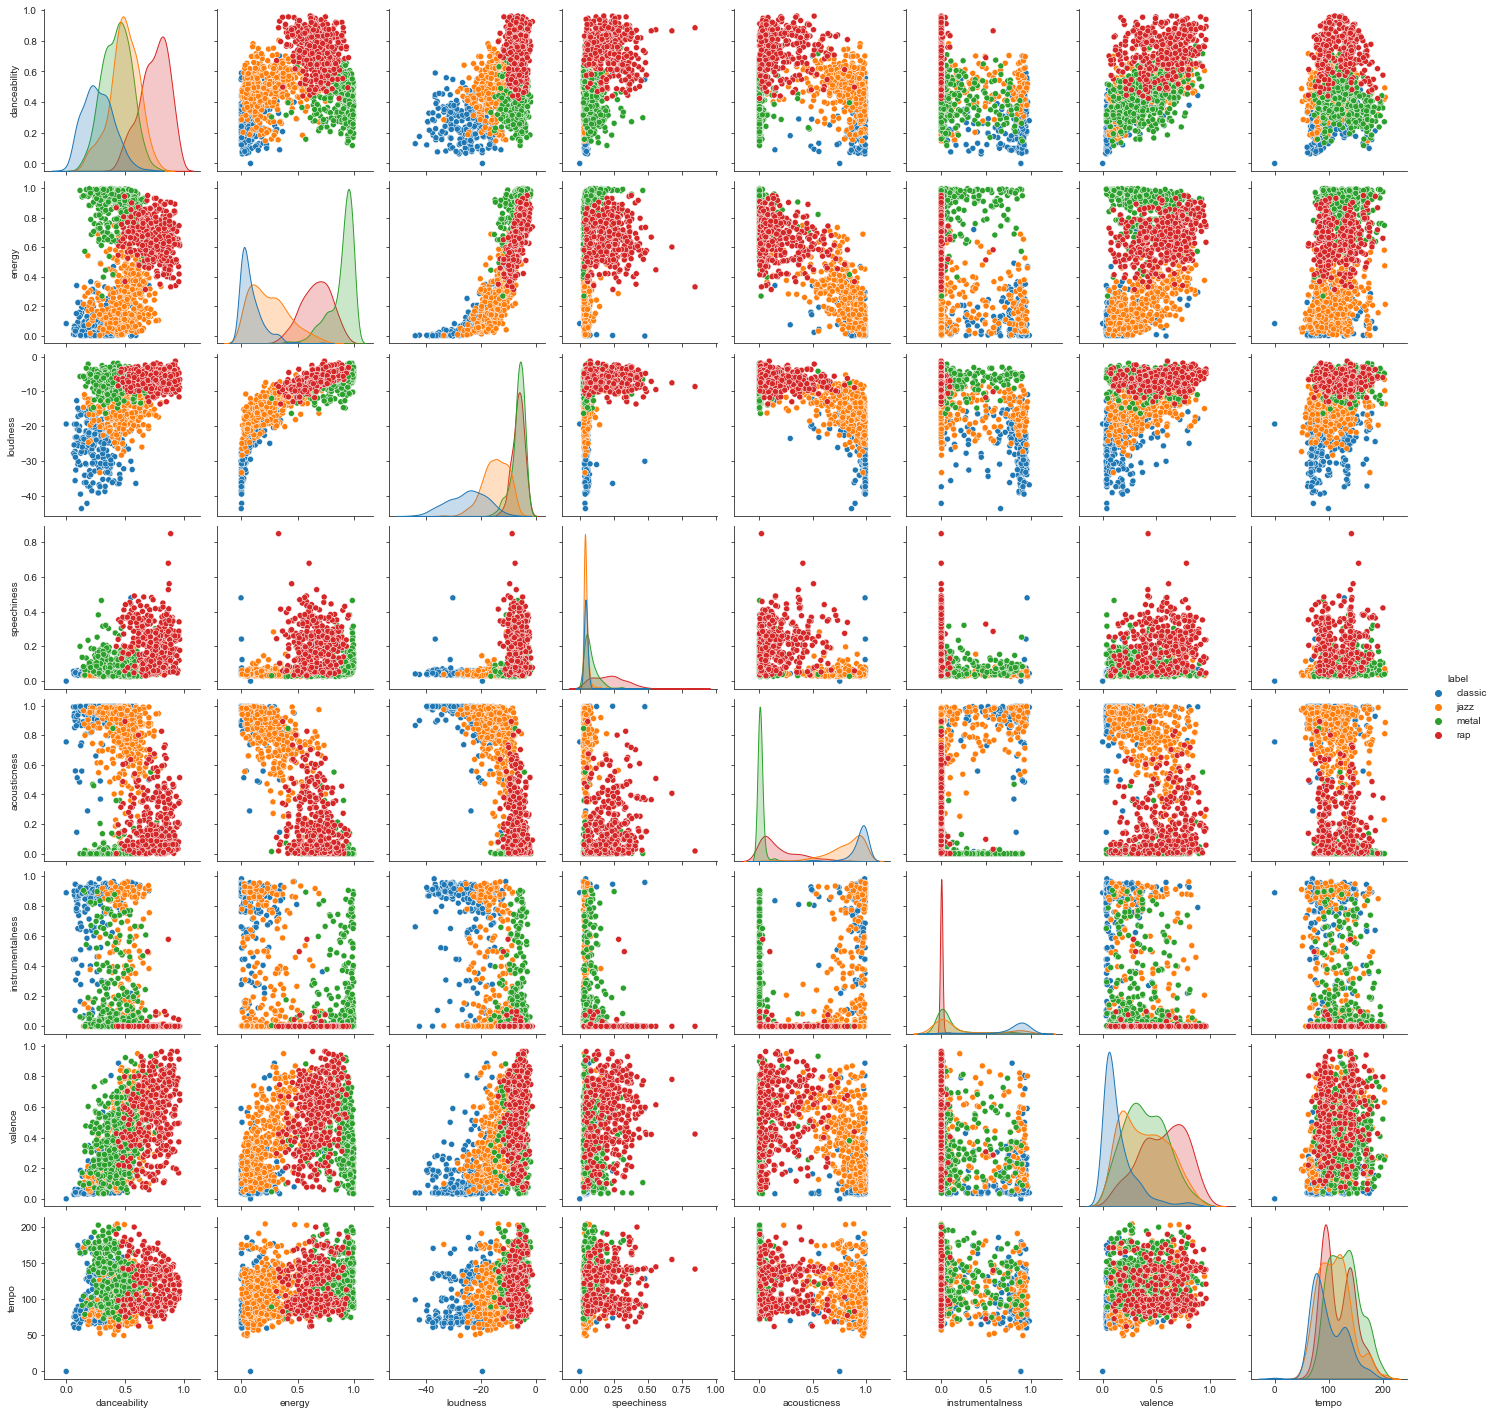

In [17]:
# We first drop some columns for an arbitrary decision.
sns.pairplot(dF.drop(['mode','key','time_signature','artist_followers','popularity','liveness','duration_ms'], axis = 1), hue="label")
plt.show()

Using just 2 dimension, in few cases we came up with well defined clusters, therefore we are curious to enter the world of unsupervised clustering methods to see what kind of results can we get. Even though we actually have the labels for each datapoint, let's see what happens if we try to cluster the set in 4 groups.

# <a id="KME"></a> Chapter 2 - Kmeans++

### Imports

In [18]:
import numpy as np
from numpy import linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')


###  Reading the csv files and dropping the unwanted columns

In [19]:
cols_to_drop = ['id', 'uri', "key", "time_signature"]

def read_csv_files(file_name, cols_to_drop=cols_to_drop): 
    df = pd.read_csv(file_name, index_col=0)
    df.drop(cols_to_drop, axis=1, inplace=True)
    
    labels = df['label']
    
    # This makes the categorical labels numbers. Print it to see...
    y = labels.factorize()[0]
    
    return df, y

df, y = read_csv_files("data\csvs\dataframeV1.csv")

df.tail(10)

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,label
40,0.547,0.568,-8.878,0,0.1970,0.63600,0.000000,0.2430,0.265,92.151,181848,rap
41,0.647,0.612,-7.442,0,0.0681,0.08710,0.000000,0.2940,0.615,145.055,154958,rap
42,0.824,0.624,-7.485,0,0.0793,0.00919,0.014700,0.1070,0.695,160.084,149062,rap
43,0.528,0.705,-7.300,0,0.1560,0.28000,0.000000,0.0876,0.485,141.280,260735,rap
44,0.846,0.546,-10.145,1,0.3300,0.20500,0.000004,0.3270,0.710,137.941,180625,rap
45,0.651,0.761,-7.801,1,0.2500,0.44600,0.000035,0.1110,0.869,139.526,150857,rap
46,0.871,0.639,-7.821,1,0.3490,0.12100,0.000000,0.1930,0.764,141.060,205957,rap
47,0.617,0.477,-9.889,1,0.3600,0.00422,0.000000,0.0830,0.436,99.095,196801,rap
48,0.850,0.564,-9.631,0,0.3830,0.23800,0.000000,0.1110,0.348,139.920,150885,rap
49,0.736,0.518,-11.607,0,0.4680,0.37900,0.000000,0.0989,0.771,142.079,137306,rap


### Standardize the data

We can drop the labels of our training data and then convert them on a single scale. We can standardize the values using the below formula.

$$x_i = \frac{{x}_i - mean(x)} {\sigma(x)} $$

It’s recommended to standardize the data to have a mean of zero and a standard deviation of one since almost always the features in any dataset would have different units of measurements such as age vs income.

In [20]:
X = df.drop(["label"], axis=1)

def standardise(X):
    # mean and standard deviation of all the features irrespective of class differences
    mean_all   = X.mean()  
    std_all    = X.std() 

    # standardised values
    X_standardised = (X-mean_all)/std_all
    return X_standardised

X_standardised = standardise(X)
X_standardised.head(10)


,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,-1.100925,-1.050292,-0.834979,0.903018,-0.373430,1.090495,1.715003,0.113724,-0.370043,-1.362347,-0.946409
1,-1.368146,-1.141622,-1.661467,0.903018,-0.563558,1.329736,1.869971,-0.530812,-0.735956,0.579970,-1.045432
2,-1.031645,-1.422685,-2.325506,-1.106597,-0.564564,1.324903,1.909417,-0.530812,-1.143451,0.321814,-0.490055
3,-2.089151,-1.306607,-1.889913,0.903018,-0.570600,1.158159,2.010851,-0.193198,-1.374226,-1.152733,0.678405
4,-1.818465,-1.047346,-0.510575,0.903018,-0.661137,0.747340,1.946046,-0.546158,-1.219128,-0.984384,0.197114
5,-1.997108,-1.413846,-1.489855,-1.106597,-0.403609,1.179908,1.681192,-0.581454,-1.419549,-1.553228,-0.526693
6,-0.601121,-1.495779,-2.427656,-1.106597,-0.433788,1.346652,2.002398,-0.636700,-1.480673,-1.409408,0.154270
7,-1.625471,-1.465404,-2.355718,-1.106597,-0.568588,1.322486,1.765720,-0.695783,-1.395848,0.403349,-0.778582
8,-0.804011,-1.498077,-2.644462,0.903018,-0.559534,1.339402,1.931958,-0.839269,-1.474852,0.530238,0.142667
9,-1.447323,-1.310731,-1.412345,-1.106597,-0.548469,1.049413,0.475261,-0.615983,-1.484831,-0.799362,0.465490


### Plot the Confusion Matrix and print the Classification Report and Accuracy Score

In [21]:
labels = ["Classic", "Jazz", "Metal", "Rap"]

def confusion_matrix_score(ytest, ypred, labels=labels):
    
    score = accuracy_score(ytest, ypred) * 100
    print(f"The accuracy score is {score:.2f}%.", end="\n\n")
    
    conf_matrix = confusion_matrix(ytest, ypred)

    sns.heatmap(conf_matrix, square=True, annot=True, fmt='d', cbar=True, lw=0.6,
                xticklabels=labels,
                yticklabels=labels)

    plt.title("Confusion Matrix", color="blue", fontsize=25)

    plt.xlabel('True Label')
    plt.ylabel('Predicted Label');

    # classification_report
    print(f"classification_report: \n{ classification_report(ytest, ypred, target_names=labels) }", end="\n\n")
    

### Explanation of k-means and k-means++

Clustering is one of the most common exploratory data analysis technique used to get an intuition about the structure of the data. It can be defined as the task of identifying subgroups in the data such that data points in the same subgroup (cluster) are very similar while data points in different clusters are very different. In other words, we try to find homogeneous subgroups within the data such that data points in each cluster are as similar as possible according to a similarity measure such as euclidean-based distance or correlation-based distance. The decision of which similarity measure to use is application-specific.

Clustering is used in market segmentation; where we try to find customers that are similar to each other whether in terms of behaviors or attributes, image segmentation/compression; where we try to group similar regions together, document clustering based on topics, etc. In our case, clustering based on music genre of either being "Classic", "Jazz", "Metal" and "Rap". 

###  Kmeans Algorithm
Kmeans algorithm is an iterative algorithm that tries to partition the dataset into "K" pre-defined distinct non-overlapping subgroups (clusters) where each data point belongs to only one group. It tries to make the intra-cluster data points as similar as possible while also keeping the clusters as different (far) as possible. It assigns data points to a cluster such that the sum of the squared distance between the data points and the cluster’s centroid (arithmetic mean of all the data points that belong to that cluster) is at the minimum. The less variation we have within clusters, the more homogeneous (similar) the data points are within the same cluster.

That is, K-means algorithm aims to choose centroids that minimise the inertia, or within-cluster sum-of-squares criterion:

$$\sum_{i=0}^n \underset{\mu_j \in \mathbf{C}}{\text{min}}(||x_i - \mu_j||^2)$$
Inertia can be recognized as a measure of how internally coherent clusters are

The way kmeans algorithm works is as follows:

1. Specify number of clusters K.
2. Initialize centroids by first shuffling the dataset and then randomly selecting K data points for the centroids without replacement.
3. Keep iterating until there is no change to the centroids. i.e assignment of data points to clusters isn’t changing.
    - Compute the sum of the squared distance between data points and all centroids.
    - Assign each data point to the closest cluster (centroid).
    - Compute the centroids for the clusters by taking the average of the all data points that belong to each cluster.

The approach kmeans follows to solve the problem is called Expectation-Maximization. 
1. The E-step is assigning the data points to the closest cluster. 
2. The M-step is computing the centroid of each cluster.

K-means itself is NP-HARD. But there are approximation algorithms that converge to a local minimum, one of which is the Lloyd's algorithm which we will use for this section of the project; though we will implement the k-means++ with a smart initialization of all the centroids as would be seen in later sections below.

#### Lloyd's Algorithm for k-means

- $\mu_1, \cdots, \mu_k \leftarrow$ randomly chosen centers
- **while** Objective function still improves **do** 
    - $S_i, \cdots, S_k \leftarrow \phi$
    - **for** i $\in$ 1,..., N **do**
        - j $\leftarrow \text{argmin}_j ||x_i - \mu_j||^2$
        - add i to $S_j$
    - **end for**
    - **for** j $\in$ 1,...,k **do**
        - $\mu_j = \frac{1}{|S_j|} \sum_{i \in S_j} x_i$
    - **end for**
- **end while**



####  k-means++

This algorithm ensures a smarter initialization of the centroids and "improves" the quality of the clustering. (Really? We shall elaborate on this later.) Apart from initialization, the rest of the algorithm is the same as the standard K-means algorithm. That is K-means++ is the standard K-means algorithm coupled with a smarter initialization of the centroids.
 
Still sensitive to outliers as we shall explain in a later section.

**Initialization**

- C $\leftarrow \text{sample a point uniformly from } \mathbf{X} $
- **while** |C| < k **do**
    - sample x $\in \mathbf{X} \text{ with probability proportional to } d^2 (x,C), \\
     \text{where d(x,C) is the distance between x and centroid C }$
    - C $\leftarrow \cup \space{} \{x\}$
- **end while**

The algorithm in plain english

1. Choose one center uniformly at random among the data points.
2. For each data point x not chosen yet, compute D(x), the distance between x and the nearest center that has already been chosen.
3. Choose one new data point at random as a new center, using a weighted probability distribution where a point x is chosen with probability proportional to $D(x)^2$.
4. Repeat Steps 2 and 3 until k centers have been chosen.
5. Now that the initial centers have been chosen, proceed using standard k-means clustering.

For the class implementation of the Kmeans++ algorithm see the end of the notebook, code section.

THe following is a wrapper function of <Confusion Matrix, Accuracy Score and Classification Report> for "matching" the true label with the cluster, assigned the mode of the labels as the class that the cluster represents.

In [22]:
from scipy import stats
def confusion_scores(y,y_pred):
    dic = {0:[], 1:[], 2:[], 3:[]}
    for i in range(len(y)):
        dic[y[i]].append(y_pred[i])
    for n in range(4):
        dic[n] = int(stats.mode(dic[n])[0])  # still have to handle cases where two clusters have the same label mode!!! if the random seed changes this can be a problem
    real = []
    for elem in y:
        real.append(dic[elem])
    real = np.array(real)
    confusion_matrix_score(real, y_pred)
    return real

###   Elbow curve

Let's see what the Elbow curve tells us about the appropriate number of clusters, we hope and expect this to be 4, because it would mean that those classes are "separated" and "differentiated" and therefore our work to predict them using those features is meaningful.

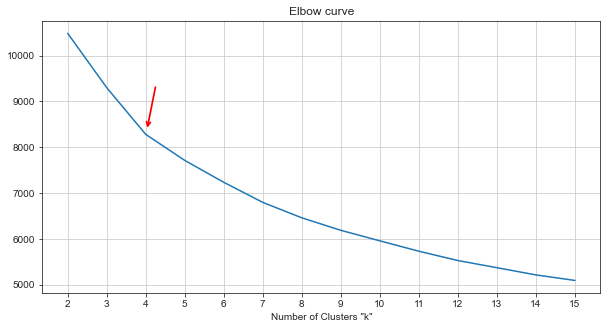

In [23]:
from sklearn.cluster import KMeans
distorsions = []
for k in range(2,16):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_standardised)
    distorsions.append(kmeans.inertia_)
fig = plt.figure(figsize=(10,5))
plt.plot(range(2,16),distorsions)
plt.grid(True)
plt.xticks(range(2,16))
plt.title('Elbow curve')
plt.annotate(None, xy=(4.03, distorsions[2]+100), xytext=(10,50), 
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', 
                            color='red',lw=1.75))
plt.xlabel('Number of Clusters "k"')
plt.show()

Even if it's not the most concise and strong curvature, we observe a great drop in dispersion when k = 4 with respect to 2 or 3, thus k=4 seems a fairly good choice for our dataset. Let's now proceed with the clustering.
We know that in real life scenarios we don't have the ground truth labels when dealing with unsupervised algorithm, but for testing purpose we come up with a kind of accuracy score for kmeans: after the algorithm has converged we compute the mode of the real labels in each cluster, and assign that cluster to represent that precise label, then compute the accuracy and confusion matrix according to that.

The accuracy score is 87.41%.

classification_report: 
              precision    recall  f1-score   support

     Classic       0.93      0.79      0.85       382
        Jazz       0.97      0.81      0.88       350
       Metal       0.85      0.98      0.91       406
         Rap       0.77      0.93      0.84       244

    accuracy                           0.87      1382
   macro avg       0.88      0.88      0.87      1382
weighted avg       0.89      0.87      0.87      1382




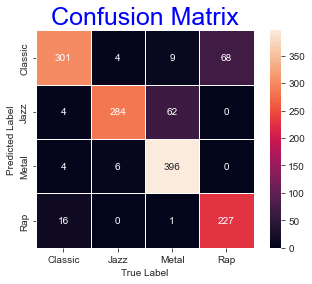

In [24]:
#Our own implementation, see the end of the notebook
from Clustering.KMeans import  KMeans_plus_plus
k = KMeans_plus_plus(K=4, init="kmeans++", rand_seed=1)   #try not to change the seed, look at the "Confusion_scores" code cell to know the reason, two cells above
y_pred = k.fit_predict(X_standardised.values).astype(np.uint8)
_ = confusion_scores(y,y_pred)

The accuracy score is 88.28%.

classification_report: 
              precision    recall  f1-score   support

     Classic       0.85      0.98      0.91       406
        Jazz       0.97      0.83      0.90       350
       Metal       0.79      0.93      0.85       244
         Rap       0.92      0.80      0.86       382

    accuracy                           0.88      1382
   macro avg       0.88      0.88      0.88      1382
weighted avg       0.89      0.88      0.88      1382




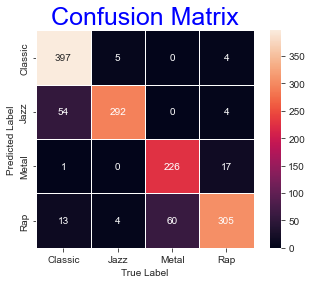

In [25]:
# sk-learn

km = KMeans(n_clusters=4, init="k-means++", random_state=1)
y_pred_2 = km.fit_predict(X_standardised)
_ = confusion_scores(y, y_pred_2)

### Clustering performance evaluation

Evaluating the performance of a clustering algorithm is not as trivial as counting the number of errors or the precision and recall of a supervised classification algorithm. In particular any evaluation metric should not take the absolute values of the cluster labels into account but rather if this clustering define separations of the data similar to some ground truth set of classes or satisfying some assumption such that members belong to the same class are more similar than members of different classes according to some similarity metric.

how can one measure clustering goodness of fit? Supervised algorithms have lots of metrics to check their goodness of fit like accuracy, r-square value, sensitivity, specificity etc. but what can we calculate to measure the accuracy or goodness of our clustering technique? The answer to this question is Silhouette Coefficient or Silhouette score.

We can also use the silhouette score to check the optimal number of clusters.

<a id="silh"></a> [**Silhouette Coefficient**](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)  
Silhouette score for a set of sample data points is used to measure how dense and well-separated the clusters are.  
If the ground truth labels are not known, evaluation must be performed using the model itself. The Silhouette Coefficient (sklearn.metrics.silhouette_score) is an example of such an evaluation, where a higher Silhouette Coefficient score relates to a model with better defined clusters. The Silhouette Coefficient is defined for each sample and is composed of two scores:  
- a: The mean distance between a sample and all other points in the same class.
- b: The mean distance between a sample and all other points in the next nearest cluster.


The Silhouette Coefficient, s, for a single sample is then given as:

$$s = \frac{b-a}{max(a,b)}$$

The Silhouette Coefficient for a set of samples is given as the mean of the Silhouette Coefficient for each sample.

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.

**Advantages**
- The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.
- The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

**Drawbacks**
- The Silhouette Coefficient is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.

### Silhouette Implementation

In [26]:

def silhouette_score(X, y, centroids):
    list_1 = []
    closest_cents = nearest_cluster(centroids, centroids)
    
    #for each cluster and its closest cluster, do
    for i, val in enumerate(closest_cents):
        print(f"Label {i} is closest to label {val}")
        
        x    = X[y==i, :]
        cent = X[y==val, :]
        
        d = sample_score(x, cent)
        list_1.extend(d)
                
    l = X.shape[0]
    return sum(list_1)/l
    

def nearest_cluster(centroids1, centroids2):
    closest_cents = []
    for val1 in centroids1 :
        list_dist = [k.euclidean_distance(val1, val2) for val2 in centroids2]
        
        #dist btw a cent and itself is 0 (minimum), but we are interested in min dist btw different centroids
        #That is, we are interested in the second min dist
        second_min_dist = np.argsort(list_dist)[1] #sorted(range(len(list_dist)), key=lambda i: list_dist[i])[1]
        
        closest_cents.append(second_min_dist)
        
    return closest_cents
    
#Array of distances btw data points
def sample_score(X1, X2):
    
    l1 = X1.shape[0] - 1  #-1 for excluding the data point itself
    l2 = X2.shape[0]
    list_sum = []
    
    for val1 in X1:
        a = get_dist(val1, X1)/l1 #for any other in-cluster data point excluding val1 itself...
        b = get_dist(val1, X2)/l2 #for all data points in the closest cluster...
        m = max(a, b)
        
        s = (b-a)/m
        list_sum.append(s)
    return list_sum

#Dist btw a single data point and all the rest
def get_dist(val1, X2):
    sum_for_single_data_point = sum( [k.euclidean_distance(val1, val2) for val2 in X2] )
    return sum_for_single_data_point
    
    
silh_score = silhouette_score(X_standardised.values, y_pred, k.centroids)
silh_score


Label 0 is closest to label 3
Label 1 is closest to label 2
Label 2 is closest to label 1
Label 3 is closest to label 0


0.221646175149614

### Silhouette Scores Plot

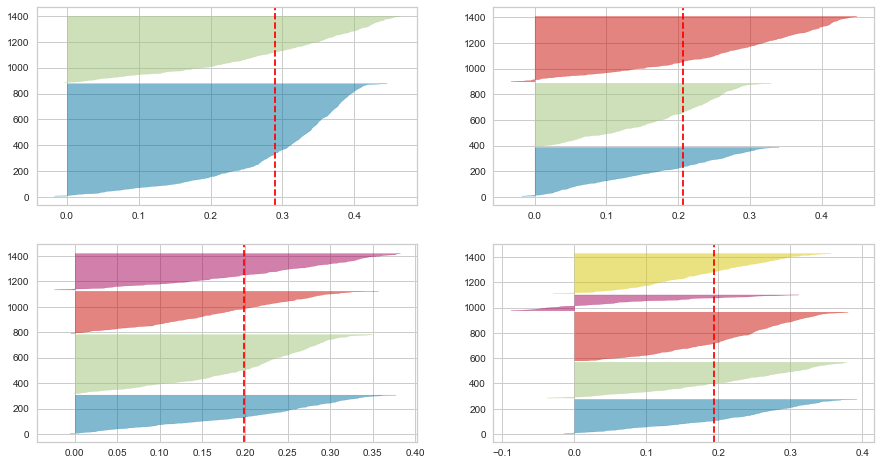

In [27]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_standardised)

We proceed with a quick Silhouette analysis done on the above plots to select an optimal value for n_clusters.
The number of clusters 2 and 5 (first and last plot) looks to be non-optimal for the given data due to the following reasons:
* A large presence of samples with negative Silhouette Score (for k = 5)
* Wide fluctuations in the size of the silhouette plots (for k = 2 and k = 5)

In conclusion 3 and 4 clusters are a better choiche in our opinion, and we are glad for it since our dataset is actually divided in 4 categories.

### Comparison between kmeans'

We do not seek to compare kmeans and kmeans++ because, unlike kmeans furthest first, they are both entirely random. After randomly choosing first centroid, kmeans++ chooses the other k-1 centroids by giving more weight to far away points than nearby ones, which makes it more sensitive to outliers than the general kmeans. However, since it was developed as an improvement over kmeans, it does often a better clustering than kmeans. That is, far away points get large probabilities, but the probabilities of the nearby ones summed together may be large. So the sample can take any according to their proportions. 

One may wonder whether or not kmeans furthest first always does a better job in clustering than kmeans. The answer is that kmeans furthest first does not always outperform kmeans. A plot would help to better understand. So let's see some plots below.

In [28]:
# uniformly create data points

np.random.seed(0)

x1 = np.random.uniform(low=1, high=10, size=50)
y1 = np.random.uniform(low=1, high=3, size=50)

x2 = np.random.uniform(low=15, high=25, size=50)
y2 = np.random.uniform(low=6, high=9, size=50)

x_outlier = np.random.uniform(low=-20,high=-3, size=2)
y_outlier = np.random.uniform(low=-30,high=-3, size=2)

xs = np.concatenate([x1, x2, x_outlier], axis=0)
ys = np.concatenate([y1, y2, y_outlier], axis=0)


In [29]:
dat = pd.DataFrame(list(zip(xs, ys)), columns = ["X1", "X2"])
dat.head(10)

,X1,X2
0,5.939322,2.140394
1,7.436704,1.877203
2,6.424870,2.976748
3,5.903949,1.204090
4,4.812893,1.417754
5,6.813047,1.322619
6,4.938285,2.306217
7,9.025957,1.506583
8,9.672965,1.932622
9,4.450974,1.488851


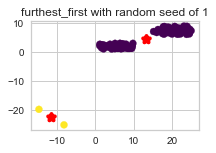

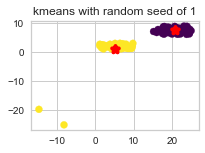

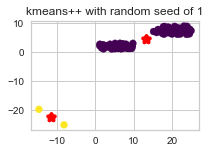

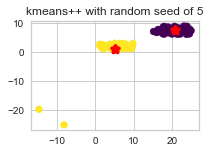

In [30]:
#kmeans beats Kmeans Furthest First for this toy example
def testing_inits(k=2, init=None, rand_seed=None):
    k_toy = KMeans_plus_plus(K=k, init=init, rand_seed=rand_seed)
    pred_k_toy = k_toy.fit_predict(dat.values)
    k_toy.centroids = np.array(k_toy.centroids)
    
    plt.figure(figsize=(3,2))
    plt.scatter(dat["X1"], dat["X2"], c=pred_k_toy, cmap='viridis')
    
    plt.scatter(k_toy.centroids[:, 0], k_toy.centroids[:, 1], marker = "*", linewidths=4, c="red")
    plt.title(init + " with random seed of " + str(rand_seed))
    plt.show()

#pred_k_toy, k_toy.centroids#, k_toy.clusters

k_p = testing_inits(k=2, init="furthest_first",rand_seed=1)
k1 = testing_inits(k=2, init="kmeans",rand_seed=1)
k1 = testing_inits(k=2, init="kmeans++",rand_seed=1)
k1 = testing_inits(k=2, init="kmeans++",rand_seed=5)

# _, ax = plt.subplots(2, 2, figsize=(10,7))
# d = {0: ["K-means", " with random seed of 1", [0,0], 1], 1: ["K-means++", " with random seed of 1",[1,0], 1], 3: ["K-means Furthest First", " with random seed of 1", [0,1], 1], 2: ["kmeans++", " with random seed of 5", [1,1], 5]}
# for i in range(4):
#     n,j = d[i][2]
#     kp = KMeans_plus_plus(K=2, init=d[i][0], rand_seed=d[i][-1])
#     pred = kp.fit_predict(dat.values)
#     ax[n][j].scatter(dat["X1"], dat["X2"], c=pred)
    
#     kp.centroids = np.asarray(kp.centroids)
#     ax[n][j].scatter(kp.centroids[:, 0], kp.centroids[:, 1], marker = "*", linewidths=4, c="red")
#     ax[n][j].set_title(d[i][0] + d[i][1])

From this toy example, when k=2, kmeans clusters the data better. However, for other k values, either Kmeans Furthest First outperforms it or they are on a par with each other. Therefore, We can conclude that Kmeans Furthest First is sensitive to outliers and does not always outperform kmeans.

Ok now we think it's time to try a different kind of clustering technique that instead deals with probability distributions, and see what type of answers can deliver

## Chapter 3 - Mixture of Gaussians 

A  mixture model (GMM) is a parametric probability density function rappresented as a weighted sum of its k components.


$$
p(x | \Theta) = \sum_{k=1}^{K} \pi_{k} \mathcal{f}(x | \Theta ) \\
$$ 

$$ 
0 \le \pi_k \le 1 , \; \forall \; k = 1, ..., K \\
$$ 

$$ 
\sum_{k=1}^{K} \pi_k = 1
$$

In this way we obtain a distribution made up of K  components. The parameter $\pi_k$ is called the mixing coefficent and rappresent how much of the rispective component is in the resulting distribution.

The complete set of parameters for the mixture model with K components is : 
 $$ 
\Theta = \{\pi_1, ..., \pi_k, \theta_1, ...., \theta_k \} \; 
 $$

If we assume to have J subgroups in our dataset $D$, each one being **Heterogenous across** and **homogeneous within**, then each subgroup will have the same parametric family differing  by the values of the parameters across the groups, then by estimating $\Theta$ we will be able to cluster unobserved realizations of $\vec{X} = \{X_1, ...., X_n\}$ of which $D = \{x_1, ..., x_n\} $ is a specific realization.

In this instance we assume that we are dealing with multivariate gaussian distributions. hence: 

$$ 
p(x | \Theta) = \sum_{k=1}^{K} \pi_{k} \mathcal{N}(x | \Theta ) \\
$$ 

$$ 
\Theta = \{\pi_1, ..., \pi_k, \mu_1,...,\mu_k,\Sigma_1,...,\Sigma_k \}
$$ 

$$ 
p_k(x|\theta_k) = \frac{1}{(2\pi)^{d/2} \sqrt{|\Sigma_k|} } e^{-\frac{1}{2}(x-\mu_k)^{t}\Sigma^{-1}_{k}(x-\mu_k)}
$$


## 3.1 - EM Algorithm

So to the question on how to estimate the parameters, trying to estimate the parameters is NP given that the Log-likelihood is not jointly concave w.r.t- the mixture parameters. 
 
Luckily we can use the Expectation Maximization Algorithm for finding the maximum likelihood estimates of a mixture (of gaussians in our case) model. As the name suggest the algorithm is divided in two steps. 



### Assumptions

* A dataset $D$ described as above where $\forall x \in D, \;\; x \in R^d$.
* Independence 

Moreover we define the membership weight $w_{i,j} = \frac{p_k(x_i|\theta_k) \pi_k}{\sum_{m=1}^{K} p_m(x_i|\theta_m) \pi_m}$

### E-step

Calculate the membership weights $w_{i,k}$ for each datapoint $x_i$,  $1 \le i \le N$ and all mixture components $1 \le k \le K$. This will yield a $N \times K$ matrix.

### M-step

**Let** $N_k = \sum_{i=1}^{N} w_{i,k}\;$ i.e. the effective number of datapoints assigned to component K.

We now update $\Theta$ as follows : 
$$
\pi_k^{new} = \frac{N_k}{N} \;\; 1 \le k \le K
$$

$$
\mu_k^{new} = (\frac{1}{N_k}) \sum_{i=1}^{N} w_{i,k}  x_i \;\; 1 \le k \le K
$$

$$
\Sigma_k^{new} = (\frac{1}{N_k}) \sum_{i=1}^{N} w_{i,k} (x_i - \mu_k^{new})(x_i - \mu_k^{new})^T \;\; 1 \le k \le K
$$

### Convergence

The algorithm takes an iterative approach where in each iteration the M-step is ran after the E-step. But how do we decide when to stop the iterations ? 

One approach is to limit the amount of iterations a priori. A better approach is to calculate at each iteration the value of the log likelihood $\log l(\Theta) = \sum_i^N \log p(x_i|\Theta)$ and stop the algorithm when no appreaciable improvment is gained w.r.t to the previous iteration. 

Note that EM does not guarantee to converge neither to a global or local minima. 

### 3.2 - Clustering with Gaussian Mixture Model

The accuracy score is 63.68%.

classification_report: 
              precision    recall  f1-score   support

     Classic       0.75      0.69      0.72       350
        Jazz       1.00      0.58      0.74       626
       Metal       0.72      0.67      0.69       406
         Rap       0.00      0.00      0.00         0

    accuracy                           0.64      1382
   macro avg       0.62      0.49      0.54      1382
weighted avg       0.85      0.64      0.72      1382




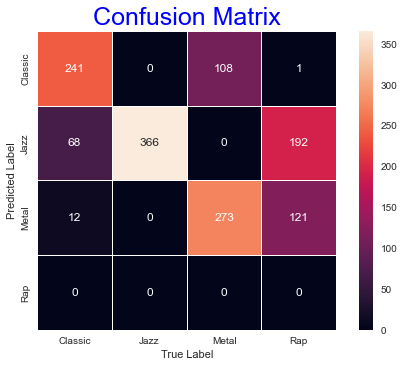

In [31]:
from MoG.MoG import GMM
gmm = GMM(4,100,random_seed=0)
gmm.fit(X_standardised.values)
y_pred = gmm.predict(X_standardised.values)
_ = confusion_scores(y,y_pred)

With this dataset, kmeans does surely a better work with respect to GMM.
Those unsupervised methods gave us some interesting outcomes, but now it's time to go back to our original line of thought and try to predict the class having a labelled dateset. Let's discover what the world of **Supervised Models** can achieve.

# <a id="naive"></a> Chapter 4 - Naive Bayes Classifier. 
Let's first get to know the calculations before the actual implementations.

Naive Bayes is a simple technique for constructing classifiers: models that assign class labels to problem instances, represented as vectors of feature values, where the class labels are drawn from some finite set. There is not a single algorithm for training such classifiers, but a family of algorithms based on a common principle: all naive Bayes classifiers assume that the value of a particular feature is independent of the value of any other feature, given the class variable. For example, a fruit may be considered to be an apple if it is red, round, and about 10 cm in diameter. A naive Bayes classifier considers each of these features to contribute independently to the probability that this fruit is an apple, regardless of any possible correlations between the color, roundness, and diameter features.

Abstractly, naive Bayes is a conditional probability model: given a problem instance to be classified, represented by a vector $ {\displaystyle \mathbf {x} =(x_{1},\ldots ,x_{n})}$ representing some n features (independent variables), it assigns to this instance probabilities
$$ {\LARGE{ \displaystyle p(C_{k}\mid x_{1},\ldots ,x_{n})\,}}$$
for each of K possible outcomes or classes ${\displaystyle C_{k}}.$


Using Bayes' theorem, the conditional probability can be decomposed as
$$ {\displaystyle p(C_{k}\mid \mathbf {x} )={\frac {p(C_{k})\ p(\mathbf {x} \mid C_{k})}{p(\mathbf {x} )}}\,} $$
In plain English, using Bayesian probability terminology, the above equation can be written as
$$ {\displaystyle {\text{posterior}}={\frac {{\text{prior}}\times {\text{likelihood}}}{\text{evidence}}}\,} $$

In practice, there is interest only in the numerator of that fraction, because the denominator does not depend on ${\displaystyle C}$ and the values of the features $\mathbf{x_{i}}$ are given, so that the denominator is effectively constant. So the evidence,
$ {\displaystyle \sum _{k}p(C_{k})\ p(\mathbf {x} \mid C_{k})}$
is a scaling factor dependent only on ${\displaystyle x_{1},\ldots ,x_{n}}$, that is, a constant if the values of the feature variables are known. So we shall drop it since it does not influence the classification.

Again, in our case, since we have four classes each of which occuring with equal probability of $\frac{1}{4}$, we can see that the **prior**, $\mathbb{P}(\mathbf{C}_k)$, is effectively constant just like the evidence above. So, we shall drop it as well.


Now we have only the **likelihood**, $p(\mathbf {x} \mid C_{k})$ , to work with. The likelihood can be rewritten as follows, using the chain rule for repeated applications of the definition of conditional probability:

$$\displaystyle{p(x_1, x_2, \ldots, x_n \mid C_k) = p(x_{1}\mid x_{2},\ldots ,x_{n},C_{k})\ p(x_{2}\mid x_{3},\ldots ,x_{n},C_{k})\cdots p(x_{n-1}\mid x_{n},C_{k})\ p(x_{n}\mid C_{k})}$$

Now the **naive** conditional independence assumptions come into play: assume that all features in $\mathbf{x}$ are mutually independent, conditional on the category $\mathbf{C_{k}}$. Under this assumption,

$$\displaystyle {p(x_{i}\mid x_{i+1},\ldots ,x_{n},C_{k})=p(x_{i}\mid C_{k})\,}.$$

Thus, the joint model, after dropping the prior and the evidence, can be expressed as **proportional** to $\prod _{i=1}^{n}p(x_{i}\mid C_{k})$


Which Distribution should we use for the joint model **proportional** to $\prod _{i=1}^{n}p(x_{i}\mid C_{k})$? Even though there are many distributions to use here, we opt for Gaussian Naive Bayes.

### Gaussian Naive Bayes.

When dealing with continuous data, a typical assumption is that the continuous values associated with each class are distributed according to a normal (or Gaussian) distribution. For example, suppose the training data contains a continuous attribute, $\mathbf{x}$. The data is first **segmented** by the class, and then the **mean** and **variance** of $\mathbf{x}$ is computed in each class. Let $\mathbf{\mu _{k}}$ be the mean of the values in $\mathbf{x}$ associated with class $\mathbf{C}_k $, and let $\mathbf{\sigma}_{k}^{2}$ be the unbiased sample variance of the values in $\mathbf{x}$ associated with class $\mathbf{C}_k $ (that is, the degree of freedom is 1 => n-1). Suppose one has collected some observation value v. Then, the probability density of v given a class $\mathbf{C}_k $, $\displaystyle{p(x=v\mid C_{k})}$, can be computed by plugging v into the equation for a normal distribution parameterized by $\displaystyle{\mu _{k}}$ and $\displaystyle{\sigma _{k}^{2}}$ as thus:


$$
\LARGE{ \mathbb{P}(\mathbf{X} = x | \mathbb{C_k}) = \frac{1}{\sqrt{2\pi\sigma_{k}^{2}}} \LARGE{e^{- \frac{(x-\mu_k)^2}{2\sigma_{k}^{2}}}} }

$$

In order to classify samples, one has to determine which posterior is greater: classic, jazz, metal or rap.

For example, for the classification as rap the posterior is given by

$$ \text{posterior(rap)} = \frac{\mathbb{P}(\text{rap})\mathbb{P}(\text{danceability|rap})...\mathbb{P}(\text{tempo|rap})\mathbb{P}(\text{timeSignature|rap})}{\text{evidence}} $$
where the

$$ \begin{align}
evidence &= \mathbb{P}(\text{classic})\mathbb{P}(\text{danceability|classic})...\mathbb{P}(\text{timeSignature|classic}) \\
        &+ \mathbb{P}(\text{jazz})\mathbb{P}(\text{danceability|jazz})...\mathbb{P}(\text{timeSignature|jazz})\\
        &+ \mathbb{P}(\text{metal})\mathbb{P}(\text{danceability|metal})...\mathbb{P}(\text{timeSignature|metal}) \\
        &+ \mathbb{P}(\text{rap})\mathbb{P}(\text{danceability|rap})...\mathbb{P}(\text{timeSignature|rap}) 
\end{align}$$
and prior = $\frac{1}{4}$



But since we know that the evidence and the prior are effectively constants, we can drop them as already explained above. Thus:

- posterior(classic) = $\mathbb{P}(\text{danceability|classic}) \dots \mathbb{P}(\text{tempo|classic})\mathbb{P}(\text{timeSignature|classic})$
- posterior(jazz) = $\mathbb{P}(\text{danceability|jazz})\dots \mathbb{P}(\text{timeSignature|jazz})$
- posterior(metal) = $\mathbb{P}(\text{danceability|metal})\dots \mathbb{P}(\text{timeSignature|metal})$ 
- posterior(rap) = $\mathbb{P}(\text{danceability|rap})\dots \mathbb{P}(\text{tempo|rap})\mathbb{P}(\text{timeSignature|rap})$

We use the ```negative log-likelihood``` since the product of a large number of small probabilities can easily underflow the numerical precision of the computer. And this is resolved by computing instead the sum of the negative log probabilities as thus:

$$\begin{align}
\large{-log\prod _{i=1}^{N}p(x_{i}\mid C_{k}) }
&=  \large{ \sum_{i=1}^N -log \left( \mathbb{P}(\mathbf{X} = x_i | \mathbb{C_k} \right)} \\
&=  \large{ \sum_{i=1}^N -log \left(\frac{1}{\sqrt{2\pi\sigma_{j,k}^{2}}}e^{- \large{ \frac{(x_i -\mu_{j,k})^2}{2\sigma_{j,k}^{2}}}} \right) }\\
&= \large{ \sum_{i=1}^N \frac{1}{2}log \left(2\pi\sigma_{j,k}^2\right) + \frac{(x_i -\mu_{j,k})^2}{2\sigma_{j,k}^{2}} }
\end{align}$$

Where k is the class label and j is the index of the feature at column j

#### Getiing the MLE for the Mean and the Variance

```LOG-LIKELIHOOD```  =  $\mathbf{\ell}(\mu_{(j,k)}, \sigma_{(j,k)}^2) = -\frac{1}{2}\sum_{i=1}^N log(2\pi) -\sum_{i=1}^N log \left(\sigma_{j,k}\right) -\frac{1}{2} \sum_{i=1}^N \frac{(x_i -\mu_{j,k})^2}{\sigma_{j,k}^{2}}
$


```MEAN```:

$$ \begin{align}
\frac{\partial \ell}{\partial \mu_{j,k}} &= -\frac{1}{2} \sum_{i=1}^N \frac{2}{\sigma_{j,k}^2} (x_i -\mu_{j,k})(-1) = 0 \\
&\implies \sum_{i=1}^N \frac{x_i - \mu_{j,k}}{\sigma_{j,k}^2} = 0 \\
&\implies \frac{1}{\sigma_{j,k}^2} \sum_{i=1}^N x_i   -\frac{1}{\sigma_{j,k}^2} \sum_{i=1}^N \mu_{j,k} = 0 \\
&\implies \sum_{i=1}^N \mu_{j,k} = \sum_{i=1}^N x_i \\
&\implies \mu_{j,k} = \frac{1}{N}\sum_{i=1}^N x_i

\end{align}$$

```VARIANCE```:

$$\begin{align}
\frac{\partial \ell}{\partial \sigma_{j,k}^2} &= -\sum_{i=1}^N \frac{1}{\sigma_{j,k}} + \sum_{i=1}^N \frac{(x_i - \mu_{j,k})^2}{\sigma_{j,k}^3} = 0 \\
& \implies \frac{-N}{\sigma_{j,k}} + \frac{1}{\sigma_{j,k}^3} \sum_{i=1}^N (x_i - \mu_{j,k})^2 = 0 \\
& \implies \frac{1}{\sigma_{j,k}^3} \sum_{i=1}^N (x_i - \mu_{j,k})^2 = \frac{N}{\sigma_{j,k}} \\
& \implies \sigma_{j,k}^2 = \frac{1}{N} \sum_{i=1}^N (x_i - \mu_{j,k})^2
\end{align}$$


Therefore, the best estimate for the mean and variance parameters of a Gaussian are simply the empirical estimates of the mean and variance respectively. These means and variances are for each feature w.r.t each class. For example, the feature danceability w.r.t rap has a mean and variance different than danceability w.r.t classic. So for each feature x, it has a mean and variance for each class c.Therefore, the means and variances must be calculated for each feature (in our case, a whopping 12 features for 4 classes). We did this in a simple one-pass by first filtering out the appropriate instances (w.r.t to the class in question) under each feature, then take the mean and variance as can be seen in the implementation below.


### Implementation of the GNB class

In [32]:

class GaussNaiveBayes(): 
    def __init__(self):
        
        #To check if the "fit" method is called to initialize all variables before calling the predict.
        self.__run_fit_first = False
        
    ##############################################################################à
    def fit(self, X, y):        
        classes = {"classic": 0, "jazz": 1, "metal": 2, "rap": 3}
        
        # Notice that these are dictionaries, rather than lists. e.g. mean_classic["danceability"]
        self.mean_classic   = self.__values_of_each_label(X, y, classes["classic"]).mean(numeric_only=True)  
        self.mean_jazz      = self.__values_of_each_label(X, y, classes["jazz"]).mean(numeric_only=True)
        self.mean_metal     = self.__values_of_each_label(X, y, classes["metal"]).mean(numeric_only=True)
        self.mean_rap       = self.__values_of_each_label(X, y, classes["rap"]).mean(numeric_only=True)
        
        #degree of freedom = 1 => (n-1)
        self.variance_classic   = self.__values_of_each_label(X, y, classes["classic"]).var(numeric_only=True, ddof=1)  
        self.variance_jazz      = self.__values_of_each_label(X, y, classes["jazz"]).var(numeric_only=True, ddof=1)
        self.variance_metal     = self.__values_of_each_label(X, y, classes["metal"]).var(numeric_only=True, ddof=1)
        self.variance_rap       = self.__values_of_each_label(X, y, classes["rap"]).var(numeric_only=True, ddof=1)
        
        #Set it to True since all the required variables have been initialized
        self.__run_fit_first = True
        
    def __values_of_each_label(self, X, y, labl):
        t = np.where(y == labl)  
        vals = X.iloc[t]
        return vals
    
    ######################################################################################à
    def predict(self, X_test): 
        
        #Raise an error message if the fit method has not been called first to initialize variables.
        assert self.__run_fit_first == True, "Please, run the 'fit' method first to train the model!."
        
        predictions = []
        
        if len(X_test) > 1:
            for row in X_test.values:
                pred = self.__prob_of_feature_given_label(row)
                m = np.argmin([pred["classic"], pred["jazz"], pred["metal"], pred["rap"]])
                predictions.append(m)
                
        #for testing single row
        elif len(X_test) == 1:
            pred = self.__prob_of_feature_given_label(X_test)
            m = np.argmin([pred["classic"], pred["jazz"], pred["metal"], pred["rap"]])
            predictions.append(m)
        
        return np.array(predictions)
        
    def __prob_of_feature_given_label(self, row):
        probs = {"classic": 0, "jazz": 0, "metal": 0, "rap": 0}
        
        for i, val in enumerate(row):
            probs["classic"] += self.__gauss_func(val, self.mean_classic.iloc[i], self.variance_classic.iloc[i])
            probs["jazz"]   +=  self.__gauss_func(val, self.mean_jazz.iloc[i], self.variance_jazz.iloc[i]) 
            probs["metal"]  +=  self.__gauss_func(val, self.mean_metal.iloc[i], self.variance_metal.iloc[i]) 
            probs["rap"]    +=  self.__gauss_func(val, self.mean_rap.iloc[i], self.variance_rap.iloc[i])
            #print(probs)
            
        return probs
        
    # After taking log of the Gaussian distribution
    def __gauss_func(self, val, mu, sigma): 
        v = (val-mu)**2
        s =  2*sigma**2
        power = v/s                                # (x-mean)^2 / 2sigma^2 after taking the log
        
        scale = 0.5*np.log(2*np.pi*sigma**2)       # 0.5*ln(2pi*sigma^2) after taking the log
        
        return scale+power
        

### Split the dataset for training and testing

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_standardised, y, stratify=y, shuffle=True, random_state=2)


### <a id="conf"></a> Plot the Confusion Matrix and print the Classification Report and Accuracy Score

In [34]:

labels = ["Classic", "Jazz", "Metal", "Rap"]

def confusion_matrix_score(ytest, ypred, labels=labels):
    
    score = accuracy_score(ytest, ypred) * 100
    print(f"The accuracy score is {score:.2f}%.", end="\n\n")
    
    conf_matrix = confusion_matrix(ytest, ypred)

    sns.heatmap(conf_matrix, square=True, annot=True, fmt='d', cbar=True, lw=0.6,
                xticklabels=labels,
                yticklabels=labels)

    plt.title("Confusion Matrix", color="blue", fontsize=25)

    plt.xlabel('True Label')
    plt.ylabel('Predicted Label');

    # classification_report
    print(f"classification_report: \n{ classification_report(ytest, ypred, target_names=labels) }", end="\n\n")
    

### <a id="train"></a> Train and Prediction

The accuracy score is 89.88%.

classification_report: 
              precision    recall  f1-score   support

     Classic       0.88      0.85      0.87        61
        Jazz       0.86      0.91      0.88        96
       Metal       0.92      0.93      0.93       102
         Rap       0.93      0.89      0.91        87

    accuracy                           0.90       346
   macro avg       0.90      0.89      0.90       346
weighted avg       0.90      0.90      0.90       346




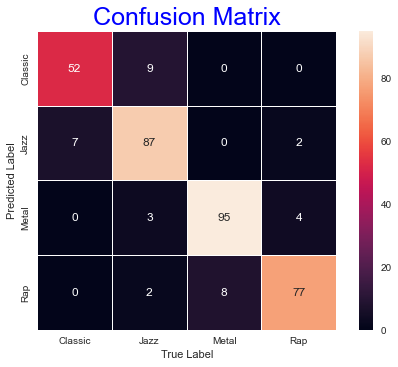

In [35]:
GNB = GaussNaiveBayes()

GNB.fit(X_train, y_train)
y_pred = GNB.predict(X_test)

confusion_matrix_score(y_test, y_pred)

# for i in list( zip(y_test, y_pred)):
#     print(i, end=' ')

### sk-learn library implementation

The accuracy score is 92.77%.

classification_report: 
              precision    recall  f1-score   support

     Classic       0.93      0.87      0.90        61
        Jazz       0.90      0.92      0.91        96
       Metal       0.94      0.96      0.95       102
         Rap       0.94      0.94      0.94        87

    accuracy                           0.93       346
   macro avg       0.93      0.92      0.92       346
weighted avg       0.93      0.93      0.93       346




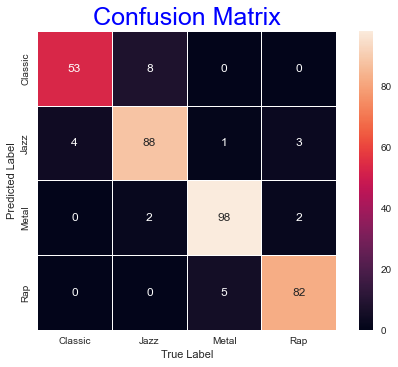

In [36]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

clf.fit(X_train, y_train)
y_pred_2 = clf.predict(X_test)

confusion_matrix_score(y_test, y_pred_2)

# for i in list( zip(y_pred_2, y_pred)):
#     print(i, end=' ')

The general accuracy is very good, even the confusion matrix is kinda uniform. The time of GNB is over now it's the moment of another wonderful classification model:

## Chapter 5 - Decision Trees


### Overview

Decision tree (DT) is a *non-parametric* supervised method used for both regression and classification. As the name suggests, DTs uses a tree-like model where each internal node rappresent a test on one (or more) attributes of our dataset, and each leaf node rappresent a class label; It follows that the branches rappresent the outcome of our test. The path from root to leaf are the classifications rules.

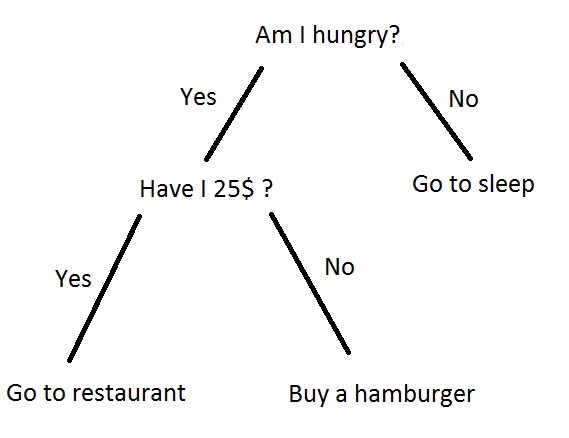

\
Decision Trees have many advantages such as : 
* Simple to understand and even visualize
* It is a *white box* model; Non parametric approach that is no assumption on the shape/distribution of the data
* Can work with both numerical and categorical values
* Easy train and fast performances



On the other hand decision trees can be very sensitive to small change in the data that can result in major change in the structure of the tree; Another problem with this approach is the danger of overfitting if not taken enough precautions. 



**So the question is how can we can construct a decision tree?**

### The building process: Reducing impurity

The algorithm to build a decision is a 'greedy' algorithm that at each node try to find the variable that **best split** the set of items in each step. So the question becomes what is considered the best split ? 

Two main metrics are used nowdays : 
* Gini impurity 
* Information Gain / Entropy impurity

In this brief project we decided to use the latter.

In general we define the information gain as:   
$$IG(T, \alpha ) = H(T) - H(T| \alpha )$$
where $$H(X) = - \sum^n_{i=1} P(x_i)logP(x_i)$$
is the entropy. 

So when building the decision tree we are trying to reduce the conditional entropy that is equivalent to maximise the information gain on each split. In simple terms we are trying to learn $\alpha$ such that our uncertainty about our observations is minimized. 

So the recursive process will be to begin with the whole dataset in the root node. We then calculate which is the best split among all features and all possible values for that feature; This will leave us with a threshold and feature on where to split. We assign to the left child of the root all observations where it's value is less or equal than the threshold and the rest to the right child. The process in then recursively repeated untill we either have all obs belonging to one class or where there are not enough observations to further split. In both cases those nodes will be the leaf nodes.


For a more Detailed implentation refer to the **DecisionTree\tree.py** python class.

## A little showcase

In [37]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [38]:
dF = pd.read_csv('data//csvs//dataframeV1.csv', index_col=0)

# Drop not usefull cols
dF = dF.drop(['id', 'uri'], axis = 1)

# Turn genres names into cat 
dF.label = pd.Categorical(dF.label)
dF['Y'] = dF.label.cat.codes
dF = dF.drop(['label'], axis = 1)

# Shuffling the dataset
dF = dF.sample(frac=1,random_state=1234).reset_index(drop=True)

dF.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Y
0,0.457,0.548,5,-12.486,0,0.0551,0.111000,0.000160,0.1030,0.760,88.800,440840,4,1
1,0.571,0.437,10,-11.839,1,0.0329,0.896000,0.032800,0.0798,0.797,83.762,166613,4,1
2,0.357,0.897,1,-6.370,1,0.0452,0.009380,0.001070,0.3180,0.406,146.272,312573,4,2
3,0.414,0.897,5,-6.406,0,0.0538,0.000402,0.000002,0.0809,0.263,170.916,255427,4,2
4,0.616,0.434,5,-7.257,0,0.0310,0.581000,0.000000,0.1310,0.404,108.467,505453,4,1


In [39]:
from DecisionTree.tree import Tree

# Creating the decision Tree
dT = Tree(random_seed=1)

In [40]:
# Prepare the dataset for the decision tree

y = dF.Y 
X = dF.drop(["Y"], axis=1)

# Split in train and validation
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=42)

In [41]:
# Fit the tree on the train set 
dT.fit(x_train.to_numpy(), y_train.to_numpy())

In [42]:
# Build the prediction over the validation set
preds = dT.predict(x_test.to_numpy())

In [43]:
# Calculate the overall accuracy.
sum(preds == y_test) / len(preds)

0.9046242774566474

Not bad at all! The decision tree can guess the class correctly > 90% of the time.

## 5.1 - Random Forest

We now try to address one of the main problems when using DTs, that is overfitting. In fact is common for such models to learn on the noise and small variations in the data, if hyper-paramethers are not carefully tuned. 

A solution to this is to use Random Forests (RF). RF is an **ensamble learning** method that operates by constructing multiple decision trees. Many decision trees are constructed applying the general technique of bootstrapping.

More formally if we have a training set $X = x_1, ..., x_n$ and the labels associated $Y = y_1, ...,y_n$ we **Bag** (Sample with replacment) from $\{X,Y\}$ $ B $ times and train a decision tree on this sample. We then in case of classification take the majority of votes from all the $B$ predictions as the final output of the RF model.

Bootstrapping so help us solve the issue of overfitting. A step further in this direction would be modify the DT algorithm slightly, by looking at each step to only a portion of the features to find the best possible split. This not only improve the overall model accuracy and speed but also provide a further guard against overfitting. 

In [44]:
from RandomForest.randomForest import Forest

So the first question is how many trees should build ? As there is no universal answer the best way to find out this hyperparameter is to use some model selection techniques. 

In [45]:
from sklearn.model_selection import cross_validate

In [46]:
parameters = {
    'max_trees' : [x for x in range(24,27)],
    'max_detph' : [4,5,6,7]
}

K = 10


res_acc = {}
res_time = {}

# Set to true if need to rerun the cross validation (note: it takes some time)
doCV = False

if doCV : 
    for b in parameters['max_trees']: 
        res_acc['T' + str(b)] = list()
        res_time['T' + str(b)] = list()
        for d in parameters['max_detph']:
            print(f"Fitting Forest ID : T{b}D{d}", end = '\r')
            score = cross_validate(Forest(max_trees=b, max_depth=6), X, y, scoring='accuracy', cv = K, n_jobs=-1 )
            res_acc['T' + str(b)].append(sum(score['test_score']) / K)
            res_time['T' + str(b)].append(sum(score['score_time']) / K)



In [47]:
if doCV : 
    acc_df = pd.DataFrame.from_dict(res_acc, orient='columns')
    acc_df = pd.concat([pd.Series(parameters['max_detph'], name = 'Depth'),acc_df], axis = 1)
    acc_df = acc_df.set_index('Depth')

    time_df = pd.DataFrame.from_dict(res_time, orient='columns')
    time_df = pd.concat([pd.Series(parameters['max_detph'], name = 'Depth'),time_df], axis = 1)
    time_df = time_df.set_index('Depth')
else : 
    acc_df = pd.read_csv('data/csvs/cv_acc_res.csv')
    acc_df = acc_df.set_index('Depth')
    time_df = pd.read_csv('data/csvs/cv_time_res.csv')
    time_df = time_df.set_index('Depth')

In [48]:
acc_df

,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14
Depth,,,,,,,,,,
2,0.864899,0.864117,0.875722,0.866364,0.883698,0.891638,0.878761,0.896007,0.875070,0.895965
3,0.868507,0.867772,0.888062,0.864863,0.886612,0.874356,0.884444,0.890142,0.903258,0.885137
4,0.856981,0.851887,0.875013,0.867006,0.856360,0.878641,0.869294,0.876535,0.890976,0.890204
5,0.862772,0.874283,0.881603,0.877182,0.883745,0.888755,0.888792,0.890929,NaN,0.900375


In [49]:
time_df

,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14
Depth,,,,,,,,,,
2,0.003406,0.003398,0.003396,0.004604,0.004599,0.005497,0.005901,0.006000,0.006400,0.008150
3,0.003199,0.003298,0.004004,0.004505,0.004999,0.005099,0.005300,0.006697,0.008098,0.008601
4,0.002901,0.003601,0.003500,0.005006,0.004996,0.005600,0.005403,0.006400,0.007600,0.008805
5,0.002952,0.003206,0.003302,0.003960,0.004996,0.005100,0.006603,0.006301,0.005504,0.007200


In [50]:
import json

save = False


if save:
    with open('cv_acc.csv', 'w') as f: 
        acc_df.to_csv(f)
        f.close()
    with open('cv_time.csv', 'w') as f: 
        time_df.to_csv(f)
        f.close()



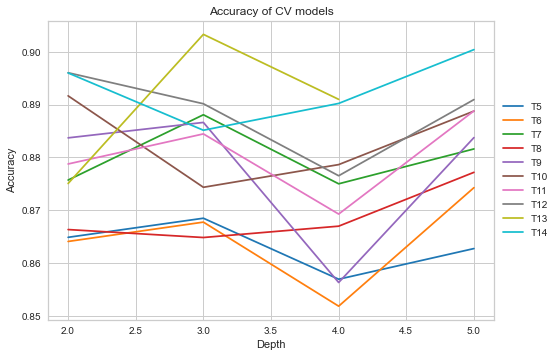

In [51]:
f = plt.figure()

acc_df.plot(ax = f.gca(), use_index = True,cmap = 'tab10')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("Accuracy of CV models")
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.show()

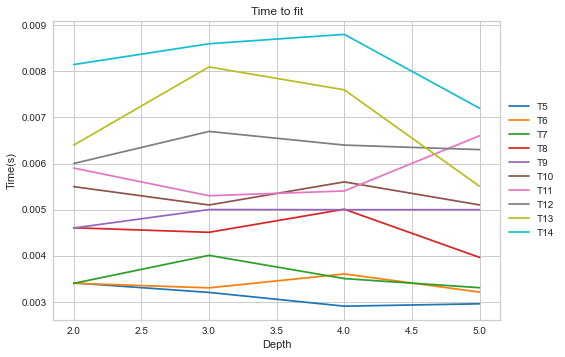

In [52]:
f = plt.figure()

time_df.plot(ax = f.gca(), use_index = True,cmap='tab10')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("Time to fit")
plt.xlabel("Depth")
plt.ylabel("Time(s)") 
plt.show()
plt.show()

From the 10-fold cross validation we get the best accuracy result with 13 Trees at maximum depth of 3, with a cross-validated result of 90.3%.
Now it's time to put an end to these musical genres prediction model, and work with another cool information present in our database, id est, the **Popularity**.

# Chapter 6 - Popularity of a song
The Spotify for Developers API provide also another type of data: a track's popularity. Using the track "id" we can retrieve, with a little code, the actual popularity value for that particular track, and add these data into our dataset.

In [53]:
CreateNewDataset = False   # Set to false cause we have already run this and the dataset with popularity is ready, see dataframeV2.csv
if CreateNewDataset:
    dF = pd.read_csv('data\csvs\dataframeV1.csv', index_col=0)

    def addPop(id):
        return spotyCarlo.track(id)['popularity']

    dF.insert(15,'popularity',np.array(list(map(addPop,dF.iloc[:,11]))))
    dF.to_csv('data\csvs\dataframeV2.csv')

dF = pd.read_csv('data\csvs\dataframeV2.csv', index_col=0).drop(['id','uri'],axis=1)
dF['duration_ms'] = dF['duration_ms']/1000
X = dF[['popularity']]
X

,popularity
0,67
1,60
2,60
3,56
4,0
...,...
45,53
46,58
47,61
48,50


But how do you quantify the popularity of a song? According to Spotify, “The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past.”

we think this value is also used for music recommendation and to build the various "Trend" playlists.

So maybe it would be cool to look how things changs if we create a dataset with very popular songs, to se what they have in common or if there is any pattern. The "Top50_clean.csv" dataset contains a set of the currently Top50 most popular songs from any country we have found on spotify. Basically we merged together the data from "Top50 Italia", "Top50 France" "Top50 Australia" and so on and so forth.

Therefore now we have 2 dataset, the one with genres label, and the Top50 one. Let's now explore a few plots and visualizations.

## 6.1 - Explore the data.

Since predicting popularity is our north star, I’m curious to see what the popularity distribution is across the dataset.

DatasetV2: mean = 43 , mode = 0
Top50_all_countries: mean = 69 , mode = 73


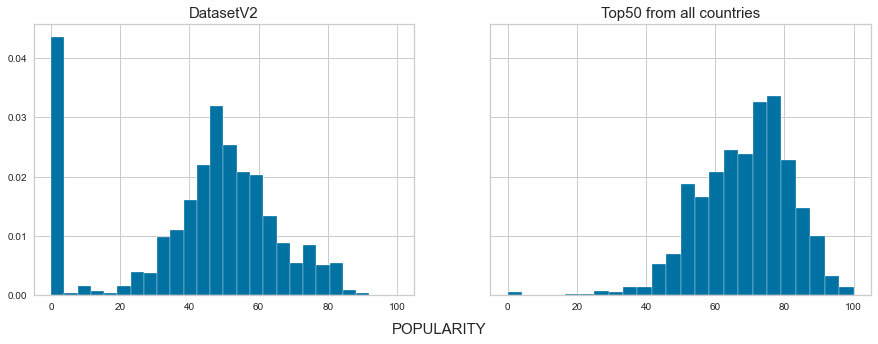

In [54]:
fig, ax = plt.subplots(ncols=2, figsize = (15,5),sharex = True, sharey = True)
dFpop = pd.read_csv('data\csvs\Top50_clean.csv', index_col=0).drop(['id','uri'],axis=1)
dFpop['duration_ms'] = dFpop['duration_ms']/1000
fig.supxlabel('POPULARITY',fontsize=15)
ax[0].set_title('DatasetV2',fontsize=15)
ax[0].hist(dF[['popularity']],density = True, bins = 24)
ax[1].set_title('Top50 from all countries',fontsize=15)
ax[1].hist(dFpop[['popularity']],density = True, bins = 24)
print('DatasetV2: mean =',int(round(dF[['popularity']].mean())),', mode =',int(dF[['popularity']].mode().iloc[0]))
print('Top50_all_countries: mean =',int(round(dFpop[['popularity']].mean())),', mode =',int(dFpop[['popularity']].mode().iloc[0]))


If we look at the leftmost histogram, the one about the almost "popularity unbiased" dataset, we see a right skewed distribution showing us how truly rare it is to have popular song. Looking at the right plot, with no surprise since we took the trending songs of various countries, we see a distribution centered near high values of popularity. 

Let's now have a look to some statistics of about popular songs:

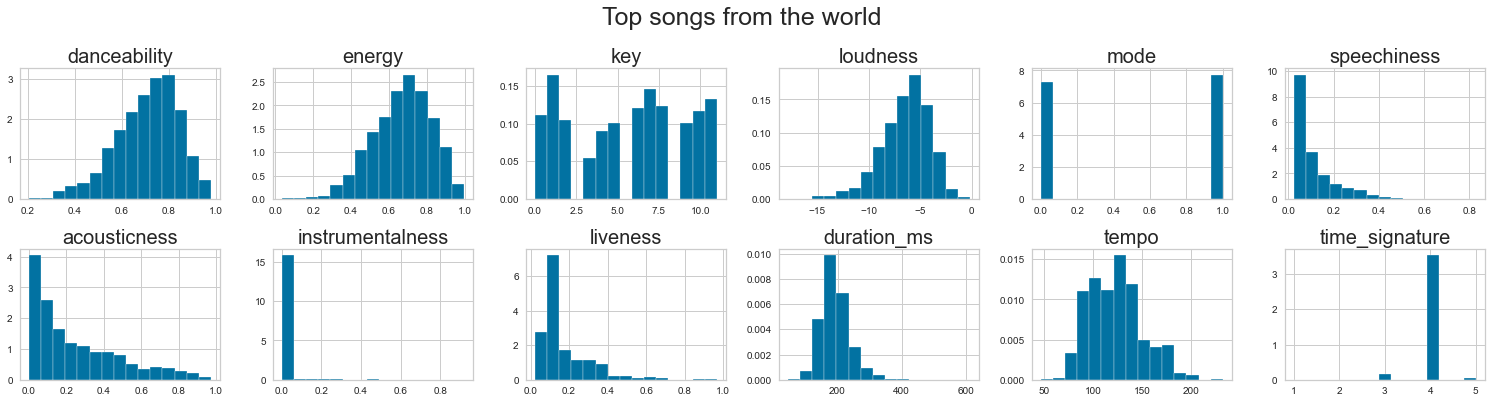

danceability        7.071826e-01
energy              6.689399e-01
loudness           -6.417846e+00
mode                5.162338e-01
speechiness         1.125265e-01
acousticness        2.493612e-01
instrumentalness    1.260278e-02
liveness            1.780320e-01
valence             5.677584e-01
tempo               1.233424e+02
duration_ms         1.928392e+02
popularity          6.870292e+01
artist_followers    4.688854e+06
dtype: float64


,tempo,duration_ms,time_signature
0,94.990,216.0,4.0
1,119.982,NaN,NaN
2,140.024,NaN,NaN


In [55]:
feat = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'duration_ms', 'tempo', 'time_signature']
_, ax = plt.subplots(ncols=len(feat)//2, nrows=2,figsize = (21,5.7)) 
for i in range(len(feat)//2):
    ax[0][i].set_title(feat[i], fontsize=20)
    ax[0][i].hist(dFpop.loc[:, feat[i]], density = True, label = feat[i], bins=15)
    ax[1][i].set_title(feat[i+6], fontsize=20)
    ax[1][i].hist(dFpop.loc[:, feat[i+6]], density = True, label = feat[i], bins=15)
plt.suptitle('Top songs from the world',fontsize=25)
plt.tight_layout()
plt.show()
print(dFpop.mean().drop(['key','time_signature']))
dFpop.mode()[['tempo','duration_ms','time_signature']]

Since we have a little background knowledge about music, we have noticed a few interesting things :
* The most common duration among trending songs is more or less 3 minute and 30 seconds, that matches with the usual Radio's songs duration. From internet. "In general, a radio-ready song is one that is three minutes, give or take 30 seconds". The mean is indeed around 3 minutes.

* We have 3 modes for the Tempo: 95 bpm, 120 bmp and 140 bpm. Those are indeed the most used Tempo in Western music. If we want to make a (statistically insignificant) example, "Shape of you" by Ed Sheeran, "Sweet Child of Mine" by Guns N' Roses and "Beat It" by Michael Jackson are played with 95,120 and 140 bpm respectively, according to a bunch of websites.

* A very common time signature is 4/4, which in music theory is indeed the basic and default time signature, also the easiest one to play and follows instrumentically.

* People like high-energy songs, better if they can dance on it (see danceability and energy mean), while they don't give much attention to vocal-free and acoustic pieces (see acousticness and instrumentalness)

* Minor tone tracks and Major tone tracks don't show any significance difference in term of popularity.

A fair question now is: is there any connection between our features and the popolarity of a song? Well, as initial guess (spoiler alert) we don't expect too much dependeces since how much a track will be famous depends a lot about external factors, as the current fashion, events happening in the world, artist's importance and reputation, social-media stuff and advertisment and so on. But let's see if we can come up with something notable.

First of all, let’s look at a correlation table to identify some baseline correlations between our many X variables. To do so we merge our two datasets onto one and see the results.

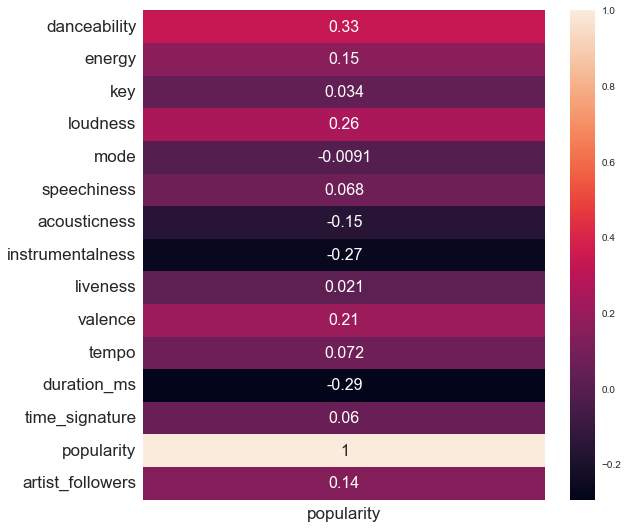

(2606, 15)

In [56]:
mergeDF = pd.concat([dF.drop('label',axis=1),dFpop]).drop_duplicates()
corr = mergeDF.corr()
x = corr[['popularity']]
fig,ax = plt.subplots(figsize=(9,9))
img = sns.heatmap(x,annot=True,annot_kws={'size':16})
img.set_yticklabels(img.get_ymajorticklabels(), fontsize = 17)
img.set_xticklabels(img.get_xmajorticklabels(), fontsize = 17)
plt.show()
mergeDF.shape

As expected, we can't see any strong correlation, the best results come with *danceability*, *loudness*, *instrumentalness* and *duration*, the latter is anticorrelated with a coefficient of -0.29. Let's try to plot those features and see what a simple Linear Regression model looks like.

## 6.2 - Linear Regression

We'll use our Linear Regression class, implemented by scratch, to se how a line fit visually the data. The first row of subplots shows a classic linear regression, the second a polynomial regression of 4th degree. We then output the R2 coefficient and Mean Absolute Error of each fit.

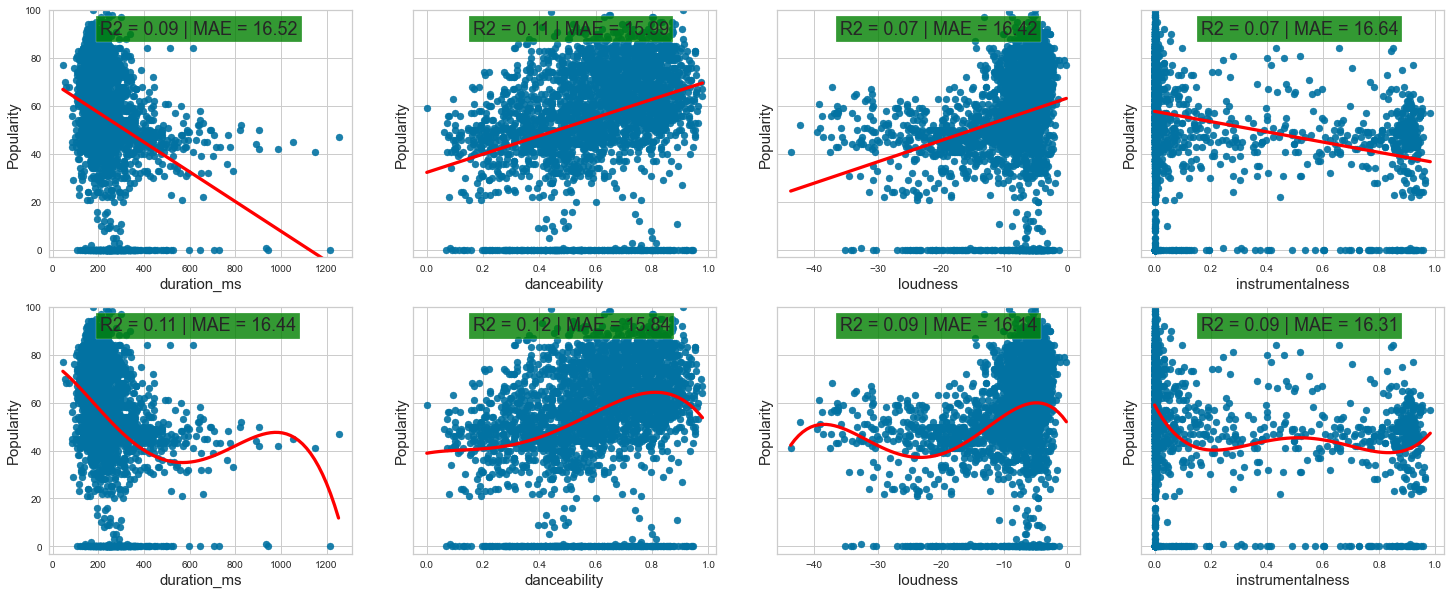

In [57]:
from GLM.LinearRegression import LinearRegression
step = 1
degree = 4
fig, ax = plt.subplots(2,4,figsize=(25,10),sharey=True)
ax[0][0].set_ylim(-3,100)
feat = ['duration_ms','danceability', 'loudness', 'instrumentalness']
LR = LinearRegression(degree = degree)
LR2 = LinearRegression()
for i in range(4):
    ax[1][i].scatter(mergeDF[feat[i]][::step],mergeDF[['popularity']][::step],alpha=0.9)
    ax[1][i].set_xlabel(feat[i],fontsize = 15)
    ax[1][i].set_ylabel('Popularity',fontsize=15)
    theta = LR.fit(mergeDF[[feat[i]]][::step],mergeDF[['popularity']][::step])
    xmin,xmax = float(mergeDF[[feat[i]]][::step].min()),float(mergeDF[[feat[i]]][::step].max())
    if xmax > 0:
        ax[1][i].text(xmax/6,90,f'R2 = {round(LR.R_squared,2)} | MAE = {round(LR.MeanAbsError,2)}',fontsize = 18, bbox = dict(facecolor = 'green', alpha = 0.8))
    else:
        ax[1][i].text(-36,90,f'R2 = {round(LR.R_squared,2)} | MAE = {round(LR.MeanAbsError,2)}',fontsize = 18, bbox = dict(facecolor = 'green', alpha = 0.8))
    bounds = np.linspace(xmin,xmax,70)[:,np.newaxis]
    Xaxis = np.insert(bounds,0,1,axis=1)
    for n in range(2,degree+1):
        Xaxis = np.concatenate((Xaxis,bounds**n),axis=1)
    def line(A):
        return A.dot(theta)
    ax[1][i].plot(bounds,line(Xaxis),color='red',lw=3.25)
    ax[0][i].scatter(mergeDF[feat[i]][::step],mergeDF[['popularity']][::step],alpha=0.9)
    ax[0][i].set_xlabel(feat[i],fontsize = 15)
    ax[0][i].set_ylabel('Popularity',fontsize=15)
    theta = LR2.fit(mergeDF[[feat[i]]][::step],mergeDF[['popularity']][::step])
    xmin,xmax = float(mergeDF[[feat[i]]][::step].min()),float(mergeDF[[feat[i]]][::step].max())
    if xmax > 0:
        ax[0][i].text(xmax/6,90,f'R2 = {round(LR2.R_squared,2)} | MAE = {round(LR2.MeanAbsError,2)}',fontsize = 18, bbox = dict(facecolor = 'green', alpha = 0.8))
    else:
        ax[0][i].text(-36,90,f'R2 = {round(LR2.R_squared,2)} | MAE = {round(LR2.MeanAbsError,2)}',fontsize = 18, bbox = dict(facecolor = 'green', alpha = 0.8))
    bounds = np.linspace(xmin,xmax,70)[:,np.newaxis]
    Xaxis = np.insert(bounds,0,1,axis=1)
    ax[0][i].plot(bounds,line(Xaxis),color='red',lw=3.25)
    

The best result is the Polynomial Regression of 4th degree using the **danceability** of the track as explanatory variable, with and R-squared coefficient of 0.12 and A Mean Absolute Error of 15.84. An average of 15.84 spread for our residuals in the prediction model for a range of 0–100 in ‘popularity’ is huge. And also R2 is low. Let's try adding a dimension.

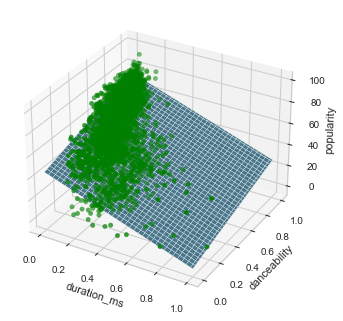

R2 = 0.14 | MAE = 15.8


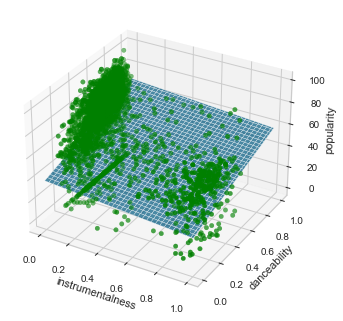

R2 = 0.12 | MAE = 15.91


In [58]:
mergeDF['duration_ms'] = (mergeDF['duration_ms'] - mergeDF['duration_ms'].min())/(mergeDF['duration_ms'].max() - mergeDF['duration_ms'].min())  #quick feature scale normalization
LR2.fit(mergeDF[['duration_ms','danceability']],mergeDF[['popularity']])
LR2.plotModel()
print('R2 =',round(LR2.R_squared,2),'| MAE =', round(LR2.MeanAbsError,2))
LR2.fit(mergeDF[['instrumentalness','danceability']],mergeDF[['popularity']])
LR2.plotModel()
print('R2 =',round(LR2.R_squared,2),'| MAE =', round(LR2.MeanAbsError,2))

Things do not really seem to get better, our goal feature is probably not really linear correlated to the others. For last let's try to use all the dimension to build the linear model and see the results.

In [59]:
theta = LR2.fit(mergeDF.drop(['popularity'],axis=1),mergeDF[['popularity']])
print('R2 =',round(LR2.R_squared,2),'| MAE =', round(LR2.MeanAbsError,2))

R2 = 0.17 | MAE = 15.48


Ok wee see our metrics going slightly better, but I’m definitely not excited about the results we’re getting with our regression methods, so perhaps it’s time to see what the classification world could offer us.
## 6.3 - Classification
In order to set up any classification model we have to move away from trying to predict a continuos integer value, and instead modelling classes/label.
So an idea could be to divide the 0 - 100 range of *"popularity"* into 3 sorted sections. Let's create three bins that represent "low","medium","high" popularity using pandas.cut() and then split the dataset into training and test set with the help of Sklearn.

In [60]:
from sklearn.model_selection import train_test_split

data = mergeDF.copy()
data = data.sample(frac=1,random_state=42).reset_index(drop=True)
data['popularity'] = pd.cut(data.popularity,bins=3)
data.popularity = pd.Categorical(data.popularity)
data['Y'] = data.popularity.cat.codes
X = data.drop(['Y','popularity'],axis=1)
y = data.Y
x_train, x_test, y_train, y_test = train_test_split(X, y,  train_size=.78, random_state = 0)
data.iloc[:,-3:]

,popularity,artist_followers,Y
0,"(-0.1, 33.333]",195753,0
1,"(-0.1, 33.333]",12528,0
2,"(33.333, 66.667]",60732,1
3,"(33.333, 66.667]",105813,1
4,"(33.333, 66.667]",45762,1
...,...,...,...
2601,"(66.667, 100.0]",1358135,2
2602,"(-0.1, 33.333]",13150903,0
2603,"(33.333, 66.667]",66,1
2604,"(66.667, 100.0]",8320686,2


First method i'm willing to try is classification using a Decision Tree and of course a Random Forest to see how an ensemble method can perform in this scenario.
## 6.4 - Decision Tree and Random Forest
We'll use our python classes built from scratch and see what this models have to offer. Let's create de Tree object, fit the model and return the accuracy over the test set.

In [61]:
from DecisionTree.tree import Tree

T = Tree(max_depth = 8,random_seed=0) 
T.fit(x_train.to_numpy(), y_train.to_numpy())
p = T.predict(x_test.to_numpy())
print(sum(p == y_test) / len(y_test))

0.6498257839721254


We now try to create a Random Forest. To select the hyperparameters needed (number of trees and maximum depth), we'll perform a 10-fold cross validation and go for the best combination.

NOTE: since it takes about 30-40 minutes to run it, we have save the result in a csv file and just show it, no need to rerun it if you don't have time to waste.

In [62]:
acc_df = pd.read_csv('data\csvs\popAccuracyCV.csv',index_col=0)
acc_df

,T10,T11,T12,T13,T14
Depth,,,,,
3,0.679394,0.681682,0.672120,0.683208,0.681691
4,0.678227,NaN,0.681304,0.677474,0.678622
5,0.681302,0.680148,0.688577,0.678635,0.680931
6,0.687038,0.686290,NaN,NaN,0.682827


Well a RF with 12 trees with a max depth of 5 seems to perform slightly better, let's select those values.

In [63]:
from RandomForest.randomForest import Forest
forest = Forest(12,5,random_seed=0)
forest.fit(x_train,y_train)
p = forest.predict(x_test)
print(sum(p == y_test) / len(y_test))

0.6149825783972126


A single deterministic Decision Tree pops out an accuracy score of 0.65 circa. So with the model we have a probability to get the label right that is twice as much as randomly choosing among 3 classes (33% if we casually pick one). But it's still not great, i would prefer something around 80-90%, because we have to remember that we have created only 3 categories over a continous range of length 100. For instance if we divide instead the dataset onto 5,10,20 bins we'll see the accuracy dropping very fast. 
With the Random Forest we don't see any major improvement, but since this method relies on *Bootstrapping* the result can change a bit over different code runs/random seeds.

The following is the code for the Cross Validation if you want to take a look.

In [64]:
# Code for k-fold cross validation

from sklearn.model_selection import cross_validate
parameters = {
    'max_trees' : [x for x in range(10,15)],
    'max_detph' : [3,4,5,6]
}
K = 10
res_acc = {}
res_time = {}
# Set to true if need to rerun the cross validation (note: it takes some time)
doCV = False

if doCV : 
    for b in parameters['max_trees']: 
        res_acc['T' + str(b)] = list()
        res_time['T' + str(b)] = list()
        for d in parameters['max_detph']:
            print(f"Fitting Forest ID : T{b}D{d}", end = '\r')
            score = cross_validate(Forest(max_trees=b, max_depth=d, random_seed = 0), X, y, scoring='accuracy', cv = K, n_jobs=-1 )
            res_acc['T' + str(b)].append(sum(score['test_score']) / K)
            res_time['T' + str(b)].append(sum(score['score_time']) / K)

    acc_df = pd.DataFrame.from_dict(res_acc, orient='columns')
    acc_df = pd.concat([pd.Series(parameters['max_detph'], name = 'Depth'),acc_df], axis = 1)
    acc_df = acc_df.set_index('Depth')

    time_df = pd.DataFrame.from_dict(res_time, orient='columns')
    time_df = pd.concat([pd.Series(parameters['max_detph'], name = 'Depth'),time_df], axis = 1)
    time_df = time_df.set_index('Depth')
else: 
    acc_df = pd.read_csv("data/csvs/popAccuracyCV.csv")

## 6.5 - Multiclass Logistic Regression

Logistic Regression is a very powerfull method when dealing with binary classification, but with the right adjustments can also handle wonderfully multiclass problems, for instance using One Versus Rest. This time let's see what Sklearn has to offer. 

In [65]:
from sklearn.preprocessing import LabelEncoder 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression(solver = 'newton-cg',multi_class='auto',max_iter=100000,n_jobs=-1)
logreg.fit(x_train,y_train)

y_pred = logreg.predict(x_test)

acc1 = accuracy_score(y_test,y_pred)
print(acc1)

0.6637630662020906


Well the accuracy is nearly the same of before, maybe we even gained some percentage points, but look at the execution time. It's the fastest algorithm tried until now.

# 7 - Conclusion
Our (and yours) journey here is finally coming to an end. We really had fun doing all of this statistical analysis and Data Science. We have found nice curiosities about songs, genres, popularity and we have observed how different models and methods performs with this kind of real-world dataset. But leaving back all the accademical purposes, we also think that a work of this type can be somehow adapted and used to build reccomendation systems, targeted advertising, trend and fashion analysis and other possible useful applications that a company can come out with. Also we are conscious that a huge amount of data are private and kept hided by Spotify, since we have to remember it is still a multimillionarie dollars company. 

To do a quick sum-up, our work dealed with:
- Data statistics and visualizations: features mean,mode,correlations, scatterplot and histograms, genres pecularities and similarities.
- Clustering Algorithms: Kmeans with different initializations such random, ++ , furthest first; Gaussian Mixture models; Evaluation metrics such Elbow method, silhouette score and plots;
- Classification models to predict the genre: GNB, DT and RF
- Regression and classification models to predict the popularity: Linear/polynomial/multiple regression, DT and RF, Logistic regression

It's been a fun and productive experience and we can't stop wondering how many other exciting studies we could do with extra data and time. We hope it was also a pleasure for the readers to take a look at our elaborate. 

Until next time,

Francesco Danese, Benjamin Barda, Yusupha Juwara
<br><br><br>

# 8 - Extra code
## Models implementation made by us, from scratch.

### Kmeans++

In [66]:
class KMeans_plus_plus:
    """
    1. furthest first when string is "in"  "furthest_first"
    2. kmeans         when string is either None or equals kmeans
    2. kmeans++       For any other string
    """
    
    def __init__(self, K=4, init="kmeans++", rand_seed=None):
        self.K = K
        self.init = init
        self.rand_seed = rand_seed
    
        # list of sample indices for each cluster
        self.clusters = [[] for _ in range(self.K)]
        # the centers (mean feature vector) for each cluster
        self.centroids = []
        self.__set_seed()

    ##########################################################################################
    # kmeans furthest first initialization
    def __initialize_centroids_further_first(self):
        
        centroids = list( self.__random_centroid(how_many_centroids=1) )
    
        ## compute the remaining k - 1 centroids
        for _ in range(self.K - 1):
            next_cent_id = self.__max_arg(centroids)
            centroids.append(self.X[next_cent_id, :])
        return np.array(centroids)

    #kmeans++ initialization
    def __plus_plus_init(self):
        # (K, d) 
        centroids = np.zeros((self.K, self.X.shape[1]), dtype=np.float32)
        # First centroid | note randint sample from discrete uniform
        centroids[0,:] = self.X[np.random.randint(low = 0, high = self.X.shape[0], size = 1), : ]

        for k in range (1, self.K) : 
            # Calculate the distance to the closest centroid for each point
            d = np.asarray([self.__min_dist(point, centroids[:k,:]) for point in self.X])
            d_sum = np.sum(d)

            # Turn the distance into probabilities that sums up to one
            d /= d_sum
        
            # sample with distance as weight the new centroid
            centroids[k, :] = self.X[np.random.choice(self.X.shape[0], p=d),:]

        return centroids         
    
    def __max_arg(self, centroids):
        return np.argmax([ self.__min_dist(point,centroids ) for point in self.X])
        
    def __min_dist(self, point, centroids):
        return min( [ self.euclidean_distance(point, centroid)**2 for centroid in centroids] ) 
    
    ##########################################################################################
    # get the how_many_centroids "centroids". 1 if k-means++, but k if k-means
    def __random_centroid(self, how_many_centroids):
        #self.__set_seed() 
        l = self.X.shape[0]
        choices = np.random.choice(l, how_many_centroids)
        return np.array(self.X[choices, :])
    
    # set the random seed for reproducibility
    def __set_seed(self):
        if self.rand_seed is not None and isinstance(self.rand_seed, int):
            np.random.seed(self.rand_seed)
    ##########################################################################################
    def fit_predict(self, X):
        self.X = X
        # print(self.X.shape)
        self.n_samples, self.n_features = X.shape

        #Initialisations...
        if self.init in 'further_first': 
            self.centroids = self.__initialize_centroids_further_first()
        elif self.init is None or self.init == "kmeans": 
            self.centroids = self.__random_centroid(how_many_centroids=self.K)
        # Kmean ++
        else: 
            self.centroids = self.__plus_plus_init()

        
                    
        #Initialize an empty array to compare with current centroids to see if convergence occurs...
        i, j = self.centroids.shape
        centroids_old = np.zeros(shape=(i, j) )

        #if the current centroids are the same as the previous centroids, then stop
        while not self.__has_converged(centroids_old, self.centroids) :
            
            # Assign samples to closest centroids (create clusters)
            self.clusters = self.__create_clusters(self.centroids)

            # Calculate new centroids from the clusters
            centroids_old = self.centroids
            self.centroids = self.__centroids_means_of_clusters(self.clusters)

        # Classify samples as the index of their clusters
        return self.__get_cluster_labels(self.clusters)

    # each sample will get the label of the cluster it was assigned to
    def __get_cluster_labels(self, clusters):
        labels = np.empty(self.n_samples)
        for cluster_idx, cluster in enumerate(clusters):
            labels[cluster] = cluster_idx
        return labels
    
    # Assign the samples to the closest centroids to create clusters; Expectation step
    def __create_clusters(self, centroids):
        clusters = [[] for _ in range(self.K)]
        for idx, sample in enumerate(self.X):
            centroid_idx = self.__closest_centroid_label(sample, centroids)
            clusters[centroid_idx].append(idx)
        return clusters
    
    # arg that minimizes the distance of the current sample to each centroid
    def __closest_centroid_label(self, point, centroids):
        return np.argmin( [ self.euclidean_distance(point, centroid)**2 for centroid in centroids] ) 

    # assign mean value of clusters to centroids; Maximisation step
    def __centroids_means_of_clusters(self, clusters):
        return [ np.mean(self.X[cluster], axis=0) for cluster in clusters]
        
    # distances between each old and new centroids
    def __has_converged(self, old_centroids, current_centroids):
        distances = [self.euclidean_distance(old_centroids[i], current_centroids[i])**2 for i in range(self.K)]
        return sum(distances) == 0
    
    def euclidean_distance(self, point1, point2):
        return la.norm(point1 - point2)
        

### Linear/polynomial/multiple regression :

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class LinearRegression():

    def __init__(self, degree = 1):
        self.degree = degree

    def fit(self,X,Y):
        self.X_copy = X.copy()
        self.X = X.copy()
        self.Y = Y.copy()
        self.X.insert(0,'intercept',1)             # building the design matrix adding column of ones (1,1,1,1,...,1)
        if self.degree > 1:                        # in case of polynomial regression
            if self.X.shape[1] != 2:
                raise Exception("ERROR: trying to do polynomial regression with multiple dimensions")                  
            for i in range(2,self.degree + 1):                                                          # "basis function" to lift up the features 
                self.X.insert(i,self.X.columns.values[1]+f'^{i}',self.X.iloc[:,1]**i)                             # create columns of powers of the first feature up to the degree selected
        self.theta = ((np.linalg.inv(self.X.T @ self.X)) @ (self.X.T) @ self.Y).to_numpy()              #closed form of linear regression
       
        #InitVar = self.Y.var() * (len(self.Y) - 1)              # Initial SSR of the explained variable in relation to their mean
        InitVar = np.sum((self.Y - self.Y.mean())**2)
        preds = self.predict(self.X_copy)
        SSR = np.sum((preds-self.Y)**2)     # Sum of Square residual after regression
        self.R_squared = float(1 - (SSR / InitVar))                    # R2
        self.MeanAbsError = float(np.sum(abs(preds-self.Y)/self.X_copy.shape[0]))
        return self.theta
            
    def predict(self, test ):
        test = np.array(test)
        if len(test.shape) ==1:
            test  = test[:, np.newaxis]
        test2 = np.insert(test,0,1,axis=1)
        if self.degree > 1:
            for i in range(2,self.degree+1):
                test2 = np.concatenate((test2,test**i),axis=1)
        return test2.dot(self.theta)
    
    def plotModel(self,xlim = 1,ylim = 1):
        if len(self.theta) == 3 and self.degree == 1:
            fig = plt.figure()
            ax = fig.add_subplot(111,projection='3d')
            xlim, ylim = np.linspace(0,xlim,70), np.linspace(0,ylim,70)
            xx, yy = np.meshgrid(xlim, ylim)
            def plane(A,B):
                return self.theta[0] + self.theta[1]*A + self.theta[2]*B
            ax.scatter(self.X_copy.iloc[:,0], self.X_copy.iloc[:,1], self.Y, color='green')
            ax.plot_surface(xx, yy, plane(xx,yy), alpha=0.7)
            ax.set_xlabel(self.X_copy.columns.values[0])
            ax.set_ylabel(self.X_copy.columns.values[1])
            ax.set_zlabel(self.Y.columns.values[0])
            plt.show()
        elif len(self.theta) == (1 + self.degree):
            plt.scatter(self.X_copy,self.Y,s=9.5,alpha=0.8)
            xmin,xmax = float(self.X_copy.min()),float(self.X_copy.max())
            bounds = np.linspace(xmin,xmax,70)[:,np.newaxis]
            Xaxis = np.insert(bounds,0,1,axis=1)
            for i in range(2,self.degree+1):
                Xaxis = np.concatenate((Xaxis,bounds**i),axis=1)
            def line(A):
                return A.dot(self.theta)
            plt.plot(bounds,line(Xaxis),color='red',lw=2)
            plt.show()
        else:
            raise Exception("ERROR: can't plot, too many dimensions")

### Decision Tree

In [68]:
import numpy as np
# from node import Node
from DecisionTree.node import Node



class Tree : 
    """
    This class provides the methods to create, tune, and use a simple decision tree 
    classification Algorithm
    """

    def __init__(self, max_depth = 6, min_sample_per_split=2, inForest = False, random_seed = None) : 
        """
        Args: 
            {int} max_depth : Max depth the tree can reach 
            {int} min_sample_per_split : Minimum number of samples in order to be able to perform a split in a node
        Return: 
            {Tree} self : Initialize the Tree object
        """

        self.in_forest = inForest

        self.max_depth = max_depth 
        self.min_sample_per_split = min_sample_per_split
        self.root = None

    
        if random_seed is not None : 
            np.random.seed(random_seed)

    def _split(self, X, thresh) : 
        """
        Split on X based on thresh

        Args : 
            {np.ndarray} X : Observations 
            {int}   thresh : value of split
        Return : 
            {np.array} left_idx  : where X <= thresh
            {np.array} right_idx : where X > thresh
        """

        left_idx = np.argwhere(X <= thresh).flatten()
        right_idx = np.argwhere(X > thresh).flatten()

        return (left_idx, right_idx)   

    def _entropyImpurity(self, Y) : 
        """
        Calculate the entropy impurity on Y

        Args: 
            {np.array} Y : Lables on which to calculate entropy impurity
        Return: 
            {float32} entropy : Entropy impurity (ref. https://en.wikipedia.org/wiki/Entropy_(information_theory) )

        """
        prop =  np.bincount(Y) / Y.shape[0]
        entropy = -np.sum([a * np.log2(a) for a in prop if a > 0])
        return entropy

    def _infGain(self, X, y, thresh) : 
        """
        Calculate the information gain.

        Args: 
            {np.ndarray} X : Observations
            {np.array}   y : Labels for X's observations
            {int}   thresh : Threshhold on which to calculate the split
        Return: 
            {int} information Gain : Information gain after the split on thresh (ref https://en.wikipedia.org/wiki/Information_gain_in_decision_trees )
        """

        my_loss = self._entropyImpurity(y)


        l_idx, r_idx = self._split(X, thresh)

        n, n_l, n_r = len(y), len(l_idx), len(r_idx)

        if n_l == 0 or n_r == 0: 
            return 0

        chid_loss = (n_l / n) * self._entropyImpurity(y[l_idx]) + (n_r / n) * self._entropyImpurity(y[r_idx])

        return my_loss - chid_loss
    
    def _bestSplit(self, X, y, features) :
        """
        Args: 
            {np.ndarray}      X : Observations
            {np.array}        y : Labels for X's observations
            {np.array} features : Features to be considered on which to look for the best split
        Return:
            {tuple(int, int)} : Feature and Threshold that best split our data based on IG.
        """
        split = {
            'score' : -1, 
            'feature' : None, 
            'threshold' : None
        }

        for feature in features : 
            X_feat = X[:, feature]
            thresholds = np.unique(X_feat)
            #TODO : try split not 
            # T <- linspace 
            for t in thresholds : 
                score = self._infGain(X_feat, y, t)
                if score > split['score'] : 
                    split['score'] = score
                    split['feature'] = feature
                    split['threshold'] = t

        return split['feature'], split['threshold']


    # Helper function to stop recursion 
    def _finished(self, depth) : 
        if depth >= self.max_depth or self.n_samples < self.min_sample_per_split or self.n_classes == 1 : 
            return True
        return False

    def _build(self, X, y, depth = 0) : 
        """
        Recursive function that build the Tree

        Args: 
            {np.ndarray} X : Observations
            {np.array}   y : Labels for X's observations
            {int}    depth : Current depth of the three
        Return: 
            {Tree} root : Save in self.root the root of the tree 
        """
        self.n_samples, self.n_features = X.shape
        self.n_classes = len(np.unique(y))


        # base case
        if self._finished(depth) :
            # This try except is more of a temp-fix ... for now it does the job but we need to check better
            try:
                return Node(value = np.argmax(np.bincount(y)))
            except(ValueError): 
                print("FAILED - EMPTY SEQ HANDLED")
                return Node()
        

        if self.in_forest:
            feats = np.random.choice(self.n_features, round(np.sqrt(self.n_features)), replace=False) 
        else: 
            feats = np.random.choice(self.n_features, self.n_features, replace=False)

        best_feat, best_thresh = self._bestSplit(X, y, feats)

        #recursive step
        l_idx, r_idx = self._split( X[:, best_feat], best_thresh)

        l = self._build( X[l_idx, :], y[l_idx], depth + 1)
        r = self._build(X[r_idx, :], y[r_idx], depth + 1)

        return Node(best_feat, best_thresh, l, r)
    
    def fit(self, X, y): 
        """
        Build the tree

        Args: 
            {np.ndarray} X : Observations
            {np.array}   y : Labels for X's observations
        Return: 
            {Tree} root : Save in self.root the root of the tree 
        """
        self.root = self._build(X,y)
    

    def _traverse(self, x, node): 
        """
        Recursive function to explore the tree

        Args: 
            {np.ndarray} x : Observation
            {np.array}   y : Labels for X's observations
        Return: 
            {int} prediction for x
        """

        if node.is_leaf():
            return node.value
        
        if x[node.feature] <= node.thresh:
            return self._traverse(x, node.left)
        return self._traverse(x, node.right)

    def predict(self, X, trgt = None) :
        """
        Bulk prediction 

        Args: 
            {np.ndarray} X : Observations
        Return: 
            {list} predictions : list of predictions on X
        """ 
        predictions = [self._traverse(x, self.root) for x in X]

        if trgt != None : 
            assert trgt.shape[0] == len(predictions) 
            acc = sum(predictions == trgt) / trgt.shape[0]

            return predictions, acc

        return predictions
        
    def __str__(self) :

        s = "tree" 
        return (s)

In [69]:
class Node : 
    """
    Class rappresenting a node in a decision Tree
    """
    def __init__(self, feature = None, thresh = None,  left = None, right = None, *, value = None) : 
        """
        Args: 
            {int} Feature    : which feature split is performed on
            {float32} thresh : threshold for the split 
            {Node} left      : left child 
            {Node} right     : right child
            {int} value      : If is leaf this is the predicted label
        Return:
            {Node} : Initialize the Node Object
        """

        self.feature = feature
        self.value = value
        self.left = left
        self.right = right
        self.thresh = thresh
    
    def is_leaf(self): 
        """
        Return: 
            {bool} : True if this node is a leaf node
        """
        return self.value is not None

### Random Forest

In [70]:
from lib2to3.pytree import Base
import numpy as np 
import pandas as pd
from DecisionTree.tree import Tree
from sklearn.base import BaseEstimator


class Forest(BaseEstimator) : 

    def __init__(self, max_trees = 10, max_depth = 6, min_sample_split = 2, random_seed = None) :

        self.rs = random_seed

        self.B = max_trees
        self.max_depth = max_depth 
        self.min_sample_split = min_sample_split 
        self.forest = list()
        self._fit = False

    def fit(self, X, y): 

        con = pd.concat([X, y.to_frame()], axis = 1)

        # Bootstrap
        for b in range(self.B): 
            df_boot = con.sample(n = len(con), replace = True, random_state=self.rs)
            y_boot = df_boot.Y.to_numpy()
            x_boot = df_boot.drop(['Y'], axis = 1).to_numpy()
            t_boot = Tree(inForest=True, random_seed=self.rs)
            t_boot.fit(x_boot, y_boot)
            self.forest.append(t_boot)

        
        self._fit = True

    def predict(self, X) :

        if type(X).__module__ != np.__name__: 
            X = X.to_numpy()


        final = list()

        if not self._fit : 
            print("Forest not yet populated")
            return -1

        # Shape = (num_trees, num_samples)
        preds = np.zeros((self.B, len(X)), dtype=np.int64)

        for b,tree in enumerate(self.forest) :
            pred = np.asarray(tree.predict(X), dtype=np.int8)
            preds[b, :] = pred
        

        for i in range(len(X)) : 
            temp = np.argmax(np.bincount(preds[:,i]))
            final.append(temp)

        return final 
    
    def score(self, X, y): 
        preds = self.predict(X)

        return sum(preds == y) / len(preds)

    def get_params(self,deep=True) : 
        return {
            'max_trees' : self.B,
            'max_depth' : self.max_depth, 
            'min_sample_split' : self.min_sample_split 
            }
    
    def set_params(self, **params):
        for parameter, value in params.items() : 
            setattr(self, parameter, value)